In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, label_binarize, LabelEncoder
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

C:\Users\adm\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RANDOM_STATE = 123
EPOCHS = 10

## **1. Обработка данных**

In [5]:
def display_data(data):
    """
    Выводит первые 5 строк, информацию о данных и описание числовых признаков.
    """
    display(data.head(5))
    display(data.info())
    display(data.describe())
    display(data.isna().sum())

In [6]:
def create_stat_plots(data, target):
    """
    Создает гистограмму и box plot для числового столбца target.
    """
    if pd.api.types.is_numeric_dtype(data[target]):
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        sns.histplot(data[target], bins=30, kde=True, ax=ax1)
        ax1.set_title(f'Histogram of {target}')
    
        sns.boxplot(x=data[target], ax=ax2)
        ax2.set_title(f'Box Plot for {target}')

        plt.tight_layout()
        plt.show()
    elif isinstance(data[target].dtype, (pd.CategoricalDtype, object)):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        sns.countplot(y=data[target], order=data[target].value_counts().index, ax=ax[0])
        ax[0].set_title(f'Count Plot of {target}')

        data[target].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        ax[1].set_title(f'Pie Chart of {target}')
        ax[1].set_ylabel('')  

        plt.tight_layout()
        plt.show()
    
    else:
        print(f"Столбец {target} имеет неподдерживаемый тип данных")

In [7]:
def fill_na_by_frequent(data, col):
    """
    Функция замены пропуска наиболее встречающимся значением
    """
    most_frequent_value = data[col].mode()[0]
    data[col] = data[col].fillna(most_frequent_value)
    print(f'Пропуск заменен на {most_frequent_value}')

In [8]:
path = '2015-street-tree-census-tree-data.csv'
raw_data = pd.read_csv(path)

In [9]:
display_data(raw_data)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,2015-08-27T00:00:00.000,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,2015-09-03T00:00:00.000,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,2015-09-05T00:00:00.000,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,2015-09-05T00:00:00.000,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,2015-08-30T00:00:00.000,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_id           683788 non-null  int64  
 1   block_id          683788 non-null  int64  
 2   created_at        683788 non-null  object 
 3   tree_dbh          683788 non-null  int64  
 4   stump_diam        683788 non-null  int64  
 5   curb_loc          683788 non-null  object 
 6   status            683788 non-null  object 
 7   health            652172 non-null  object 
 8   spc_latin         652169 non-null  object 
 9   spc_common        652169 non-null  object 
 10  steward           164350 non-null  object 
 11  guards            79866 non-null   object 
 12  sidewalk          652172 non-null  object 
 13  user_type         683788 non-null  object 
 14  problems          225844 non-null  object 
 15  root_stone        683788 non-null  object 
 16  root_grate        68

None

,tree_id,block_id,tree_dbh,stump_diam,postcode,community board,borocode,cncldist,st_assem,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000,677269.000000,677269.000000,6.742290e+05,6.742290e+05
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424625,30.027330,11957.368422,3.495439e+06,3.413414e+09
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114,14.301717,30745.739811,1.193275e+06,1.174892e+09
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792200,1.000000,1.000000,1.000000e+06,0.000000e+00
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153700,19.000000,202.000000,3.031991e+06,3.011240e+09
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252500,30.000000,516.000000,4.020352e+06,4.008560e+09
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571950,43.000000,1417.000000,4.263123e+06,4.105700e+09
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092100,51.000000,157903.000000,5.515124e+06,5.080500e+09


tree_id                  0
block_id                 0
created_at               0
tree_dbh                 0
stump_diam               0
curb_loc                 0
status                   0
health               31616
spc_latin            31619
spc_common           31619
steward             519438
guards              603922
sidewalk             31616
user_type                0
problems            457944
root_stone               0
root_grate               0
root_other               0
trunk_wire               0
trnk_light               0
trnk_other               0
brch_light               0
brch_shoe                0
brch_other               0
address                  0
postcode                 0
zip_city                 0
community board          0
borocode                 0
borough                  0
cncldist                 0
st_assem                 0
st_senate                0
nta                      0
nta_name                 0
boro_ct                  0
state                    0
l

Описание колонок:
 - tree_id - Уникальный идентификационный номер для каждой точки дерева - удаляю, т.к. по сути является просто значением id
 - block_id - Идентификатор, связывающий каждое дерево с блоком в таблице блока/файле формы, на который оно отображено - удаляю, т.к. по сути является просто значением id
 - created_at - В программном обеспечении для переписи были собраны точки датировки деревьев - удаляю, т.к. это временная метка, когда были сняты данные для дерева
 - tree_dbh - Диаметр дерева, измеренный на высоте примерно 54" / 137 см над землей. Данные собирались как для живых, так и для мертвых деревьев; для пней используйте stump_diam
 - stump_diam - Диаметр пня, измеренный через центр, округленный до ближайшего дюйма.
 - curb_loc - Расположение клумбы по отношению к бордюру; деревья располагаются либо вдоль бордюра (OnCurb), либо со смещением от бордюра (OffsetFromCurb)
 - status - Указывает, является ли дерево живым, мертвым или пнем.
 - health - Указывает на восприятие пользователем состояния деревьев. - **целевой признак**
 - spc_latin - Научное название вида, например, "Acer rubrum". 
 - spc_common - Общее название вида, например, "красный клен".
 - steward - Указывает количество уникальных признаков бережного отношения, отмеченных для этого дерева. Не регистрируется для пней или мертвых деревьев.
 - guards - Указывает, присутствует ли ограждение, и считает ли пользователь, что оно полезно или вредно. Не регистрируется для мертвых деревьев и пней.
 - sidewalk - Указывает, был ли поврежден, треснут или поднят один из флажков тротуара, непосредственно примыкающий к дереву. Не регистрируется для мертвых деревьев и пней.
 - user_type - Это поле описывает категорию пользователя, собравшего данные об этой точке дерева.
 - problems - Комментарии с проблемам от пользователей - признак удаляю, т.к. признаки ниже описывают примерно те же проблемы
 - root_stone - Указывает на наличие проблемы с корнями, вызванной брусчаткой в ложе дерева
 - root_grate - Указывает на наличие проблемы с корнями, вызванной металлическими решетками в ложе дерева
 - root_other - Указывает на наличие других корневых проблем
 - trunk_wire - Указывает на наличие проблемы со стволом, вызванной проволокой или веревкой, обмотанной вокруг ствола
 - trnk_light - Указывает на наличие проблем со стволом, вызванных установленным на дереве освещением
 - trnk_other - Указывает на наличие других проблем со стволом
 - brch_light - Указывает на наличие проблем с ветвями, вызванных светильниками (обычно струнными) или проводами в ветвях
 - brch_shoe - Указывает на наличие проблемы с ветками, вызванной кроссовками в ветках
 - brch_other - Указывает на наличие других проблем с ветками
 - address - Ближайший предполагаемый адрес к дереву - признак удаляю как неинформативный
 - postcode - Пятизначный почтовый индекс, в котором находится дерево - признак удаляю как неинформативный
 - zip_city - Город, полученный из почтового индекса. Часто (но не всегда) это то же самое, что и район.
 - community board - Общественный совет, в котором находится точка произрастания дерева
 - borocode - Код района, в котором находится точка дерева: 1 (Манхэттен), 2 (Бронкс), 3 (Бруклин), 4 (Квинс), 5 (Статен-Айленд)
 - borough - Название района, в котором находится точка произрастания деревьев
 - cncldist - Район совета, в котором находится точка дерева
 - st_assem - Округ Ассамблеи штата, в котором находится точка дерева
 - st_senate - Сенатский округ штата, в котором находится точка дерева
 - nta - Это код NTA, соответствующий району табуляции района по переписи населения США 2010 года, в который попадает данная точка дерева.
 - nta_name - Это название NTA, соответствующее району табуляции района из переписи населения США 2010 года, в который попадает данная точка дерева.
 - boro_ct - Это идентификатор boro_ct для переписного участка, в который попадает данная точка дерева.
 - state - Всем характеристикам присвоено значение "Нью-Йорк" - точно можно удалить
 - latitude - Широта точки, в десятичных градусах
 - longitude - Долгота точки, в десятичных градусах
 - x_sp - Координата X в плоскости государства. Единицы измерения - футы.
 - y_sp - Координата Y в государственной плоскости. Единицы измерения - футы
 - council district - 
 - census tract - 
 - bin - 
 - bbl - 

### **1.1 Обработка пропусков**

In [12]:
print('Всего пропусков в "health" -', round(raw_data['health'].isna().mean() * 100, 2), '%')

Всего пропусков в "health" - 4.62 %


В целевом признаке health наблюдаются пропуски. Поскольку эти данные не помогут при обучении модели, от них можно избавиться.

In [14]:
raw_data = raw_data.dropna(subset=['health'])

In [15]:
raw_data['health'].isna().sum()

0

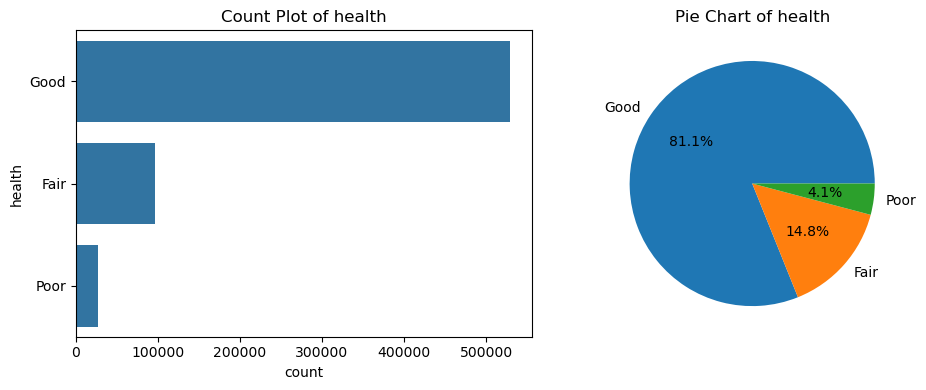

In [16]:
create_stat_plots(raw_data, 'health')

В целевом признаке наблюдается дисбаланс классов

In [18]:
raw_data.duplicated().sum()

0

Полных дубликатов нет

Создам "подготовленную" дату, на основе сырой и буду постепенно вносить корректировки в данные

In [21]:
prepared_data = raw_data.drop(['tree_id', 'block_id', 'created_at', 'spc_latin', 'problems', 'address', 'postcode', 'nta', 'nta_name', 'state'], axis=1)

In [22]:
display_data(prepared_data)

,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,user_type,...,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,3,0,OnCurb,Alive,Fair,red maple,NaN,NaN,NoDamage,TreesCount Staff,...,16,4073900,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,21,0,OnCurb,Alive,Fair,pin oak,NaN,NaN,Damage,TreesCount Staff,...,11,4097300,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,3,0,OnCurb,Alive,Good,honeylocust,1or2,NaN,Damage,Volunteer,...,18,3044900,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,10,0,OnCurb,Alive,Good,honeylocust,NaN,NaN,Damage,Volunteer,...,18,3044900,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,21,0,OnCurb,Alive,Good,American linden,NaN,NaN,Damage,Volunteer,...,21,3016500,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


<class 'pandas.core.frame.DataFrame'>
Index: 652172 entries, 0 to 683787
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_dbh          652172 non-null  int64  
 1   stump_diam        652172 non-null  int64  
 2   curb_loc          652172 non-null  object 
 3   status            652172 non-null  object 
 4   health            652172 non-null  object 
 5   spc_common        652167 non-null  object 
 6   steward           164350 non-null  object 
 7   guards            79866 non-null   object 
 8   sidewalk          652171 non-null  object 
 9   user_type         652172 non-null  object 
 10  root_stone        652172 non-null  object 
 11  root_grate        652172 non-null  object 
 12  root_other        652172 non-null  object 
 13  trunk_wire        652172 non-null  object 
 14  trnk_light        652172 non-null  object 
 15  trnk_other        652172 non-null  object 
 16  brch_light        652172 

None

,tree_dbh,stump_diam,community board,borocode,cncldist,st_assem,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
count,652172.000000,652172.0,652172.000000,652172.000000,652172.000000,652172.000000,652172.000000,6.521720e+05,652172.000000,652172.000000,6.521720e+05,652172.000000,645966.000000,645966.000000,6.430690e+05,6.430690e+05
mean,11.709478,0.0,343.738144,3.360977,29.992944,50.818086,20.620720,3.407337e+06,40.700991,-73.924587,1.005134e+06,194699.781289,30.078239,11973.235805,3.497817e+06,3.415879e+09
std,8.634244,0.0,115.808246,1.167571,14.343654,18.928946,7.378432,1.176611e+06,0.090267,0.123843,3.435708e+04,32886.094006,14.316280,30777.460217,1.193729e+06,1.175564e+09
min,0.000000,0.0,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792200,1.000000,1.000000,1.000000e+06,0.000000e+00
25%,5.000000,0.0,303.000000,3.000000,19.000000,33.000000,14.000000,3.012000e+06,40.631725,-73.980973,9.895260e+05,169441.827675,19.000000,202.000000,3.032695e+06,3.011480e+09
50%,10.000000,0.0,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700287,-73.913449,1.008235e+06,194444.889350,30.000000,515.000000,4.020342e+06,4.008560e+09
75%,16.000000,0.0,412.000000,4.000000,43.000000,64.000000,25.000000,4.103300e+06,40.761999,-73.835219,1.029902e+06,216940.392375,43.000000,1417.000000,4.264056e+06,4.105810e+09
max,425.000000,0.0,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092100,51.000000,157903.000000,5.515124e+06,5.080500e+09


tree_dbh                 0
stump_diam               0
curb_loc                 0
status                   0
health                   0
spc_common               5
steward             487822
guards              572306
sidewalk                 1
user_type                0
root_stone               0
root_grate               0
root_other               0
trunk_wire               0
trnk_light               0
trnk_other               0
brch_light               0
brch_shoe                0
brch_other               0
zip_city                 0
community board          0
borocode                 0
borough                  0
cncldist                 0
st_assem                 0
st_senate                0
boro_ct                  0
latitude                 0
longitude                0
x_sp                     0
y_sp                     0
council district      6206
census tract          6206
bin                   9103
bbl                   9103
dtype: int64

Очень большое количество пропусков в steward и guards. В описании к данным отмечено, что для мертвых деревьев и пней не указывается

In [24]:
prepared_data.loc[prepared_data['steward'].notna() & (prepared_data['status'] == 'Alive')].head(5)

,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,user_type,...,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
2,3,0,OnCurb,Alive,Good,honeylocust,1or2,NaN,Damage,Volunteer,...,18,3044900,40.717581,-73.936608,1.001823e+06,200716.8913,34.0,449.0,3338310.0,3.028870e+09
5,11,0,OnCurb,Alive,Good,honeylocust,1or2,Helpful,NoDamage,Volunteer,...,27,1014500,40.770046,-73.984950,9.884187e+05,219825.5227,3.0,145.0,1076229.0,1.011310e+09
6,11,0,OnCurb,Alive,Good,honeylocust,1or2,Helpful,NoDamage,Volunteer,...,27,1014500,40.770210,-73.985338,9.883112e+05,219885.2785,3.0,145.0,1076229.0,1.011310e+09
13,22,0,OnCurb,Alive,Good,London planetree,3or4,Harmful,NoDamage,Volunteer,...,25,3019100,40.694733,-73.968211,9.930653e+05,192388.0651,35.0,191.0,3054331.0,3.018880e+09
14,30,0,OnCurb,Alive,Fair,London planetree,1or2,NaN,Damage,Volunteer,...,20,3090000,40.664317,-73.921130,1.006131e+06,181314.9855,41.0,900.0,3081177.0,3.035310e+09


Посмотрим на признаки

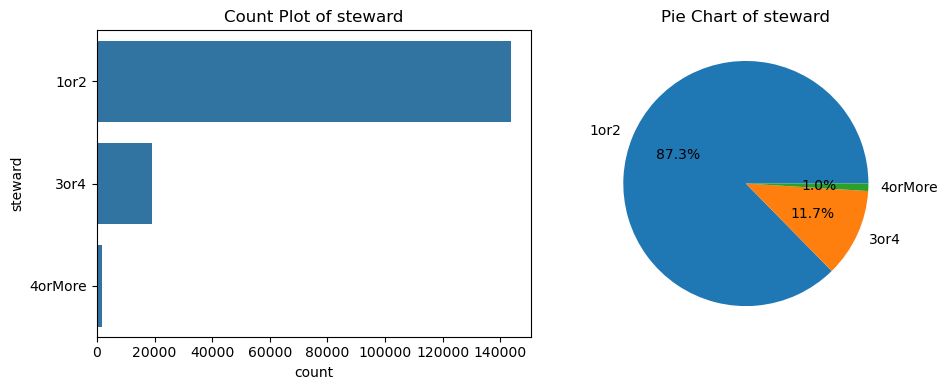

In [26]:
create_stat_plots(prepared_data, 'steward')

In [27]:
print('Всего пропусков в "steward" -', round(prepared_data['steward'].isna().mean() * 100, 2), '%')

Всего пропусков в "steward" - 74.8 %


Предположу, что если не отмечено что за деревом было "бережное отношение", это можно интерпретировать как отсутвие бережного отношения или неизвестность, и для всех пропусков назначить новую категорию - 'Unknown' 

In [29]:
prepared_data['steward'] = prepared_data['steward'].fillna('unknown')

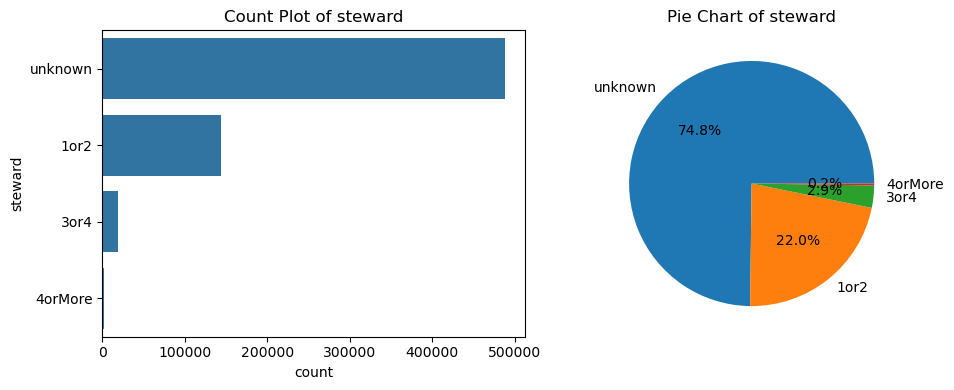

In [30]:
create_stat_plots(prepared_data, 'steward')

Несбалансированный признак

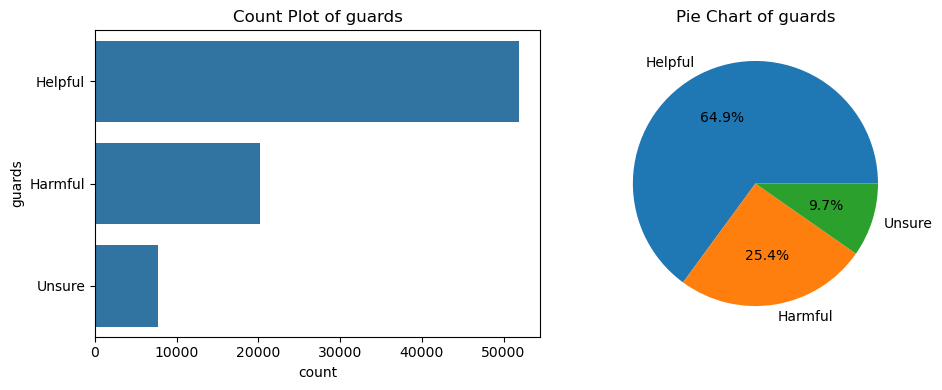

In [32]:
create_stat_plots(prepared_data, 'guards')

In [33]:
print('Всего пропусков в "guards" -', round(prepared_data['guards'].isna().mean() * 100, 2), '%')

Всего пропусков в "guards" - 87.75 %


Предположу, что если не отмечено что забор вреден/полезен или неуверен, это может означать отсутвие забора, например. В таком случае предлага также заменить пропуски на 'Unknown'

In [35]:
prepared_data['guards'] = prepared_data['guards'].fillna('unknown')

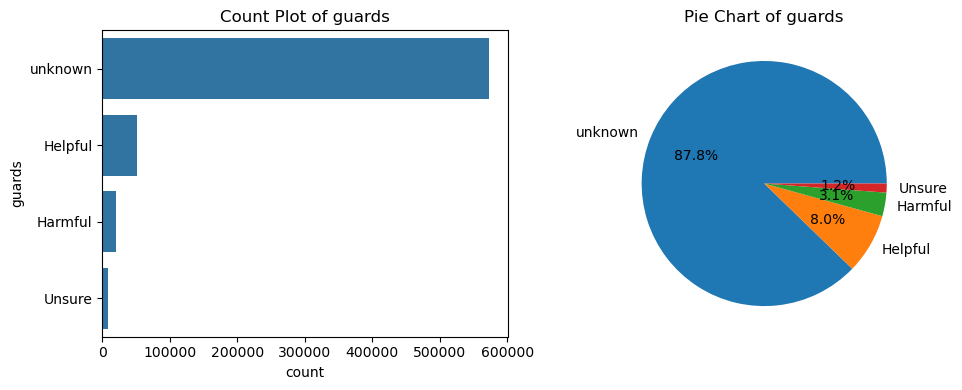

In [36]:
create_stat_plots(prepared_data, 'guards')

Несбалансированный признак

In [38]:
prepared_data.loc[prepared_data['spc_common'].isna()]

,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,user_type,...,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
356613,4,0,OnCurb,Alive,Good,NaN,1or2,unknown,NoDamage,TreesCount Staff,...,11,4099100,40.791332,-73.803610,1038630.469,227641.3712,19.0,991.0,4103675.0,4.045570e+09
427541,11,0,OnCurb,Alive,Poor,NaN,unknown,unknown,Damage,TreesCount Staff,...,11,4148300,40.771945,-73.750414,1053380.635,220615.7964,19.0,1483.0,4168471.0,4.080630e+09
431417,40,0,OnCurb,Alive,Good,NaN,unknown,unknown,Damage,TreesCount Staff,...,15,4000800,40.686902,-73.859411,1023240.372,189564.7945,32.0,8.0,4185286.0,4.089630e+09
608632,5,0,OnCurb,Alive,Good,NaN,1or2,unknown,NoDamage,NYC Parks Staff,...,15,4067100,40.723484,-73.880296,1017429.853,202884.0907,30.0,671.0,4067282.0,4.029350e+09
656960,3,0,OnCurb,Alive,Good,NaN,1or2,unknown,Damage,Volunteer,...,36,2042000,40.894521,-73.858255,1023438.408,265207.8056,11.0,420.0,2068064.0,2.049940e+09


Неизвестные виды у 5 деревьев. Эти неизвестные значения можно заменить на Unknown

In [40]:
prepared_data['spc_common'] = prepared_data['spc_common'].fillna('unknown')

In [41]:
prepared_data['spc_common'].unique()

array(['red maple', 'pin oak', 'honeylocust', 'American linden',
       'London planetree', 'ginkgo', 'willow oak', 'sycamore maple',
       'Amur maple', 'hedge maple', 'American elm', 'ash', 'crab apple',
       'silver maple', 'Turkish hazelnut', 'black cherry',
       'eastern redcedar', 'Norway maple', 'tulip-poplar', 'sawtooth oak',
       'swamp white oak', 'Sophora', 'Chinese fringetree',
       'southern magnolia', 'sweetgum', 'Callery pear', 'scarlet oak',
       'Atlantic white cedar', 'black oak', 'Japanese zelkova',
       'white oak', 'Ohio buckeye', 'northern red oak', 'silver linden',
       'pignut hickory', 'Kentucky yellowwood', 'mulberry', 'Douglas-fir',
       'crepe myrtle', 'sassafras', 'cherry', 'spruce', 'Chinese elm',
       'horse chestnut', 'holly', 'littleleaf linden', 'white pine',
       'blackgum', 'Japanese tree lilac', 'hardy rubber tree',
       'green ash', 'English oak', 'white ash', 'golden raintree',
       "Schumard's oak", 'Siberian elm', 'black

In [42]:
prepared_data['spc_common'].nunique()

133

для исключения повторов приведу все к нижнему регистру

In [44]:
prepared_data['spc_common'] = prepared_data['spc_common'].str.lower()

In [45]:
prepared_data['spc_common'].unique()

array(['red maple', 'pin oak', 'honeylocust', 'american linden',
       'london planetree', 'ginkgo', 'willow oak', 'sycamore maple',
       'amur maple', 'hedge maple', 'american elm', 'ash', 'crab apple',
       'silver maple', 'turkish hazelnut', 'black cherry',
       'eastern redcedar', 'norway maple', 'tulip-poplar', 'sawtooth oak',
       'swamp white oak', 'sophora', 'chinese fringetree',
       'southern magnolia', 'sweetgum', 'callery pear', 'scarlet oak',
       'atlantic white cedar', 'black oak', 'japanese zelkova',
       'white oak', 'ohio buckeye', 'northern red oak', 'silver linden',
       'pignut hickory', 'kentucky yellowwood', 'mulberry', 'douglas-fir',
       'crepe myrtle', 'sassafras', 'cherry', 'spruce', 'chinese elm',
       'horse chestnut', 'holly', 'littleleaf linden', 'white pine',
       'blackgum', 'japanese tree lilac', 'hardy rubber tree',
       'green ash', 'english oak', 'white ash', 'golden raintree',
       "schumard's oak", 'siberian elm', 'black

In [46]:
prepared_data['spc_common'].nunique()

133

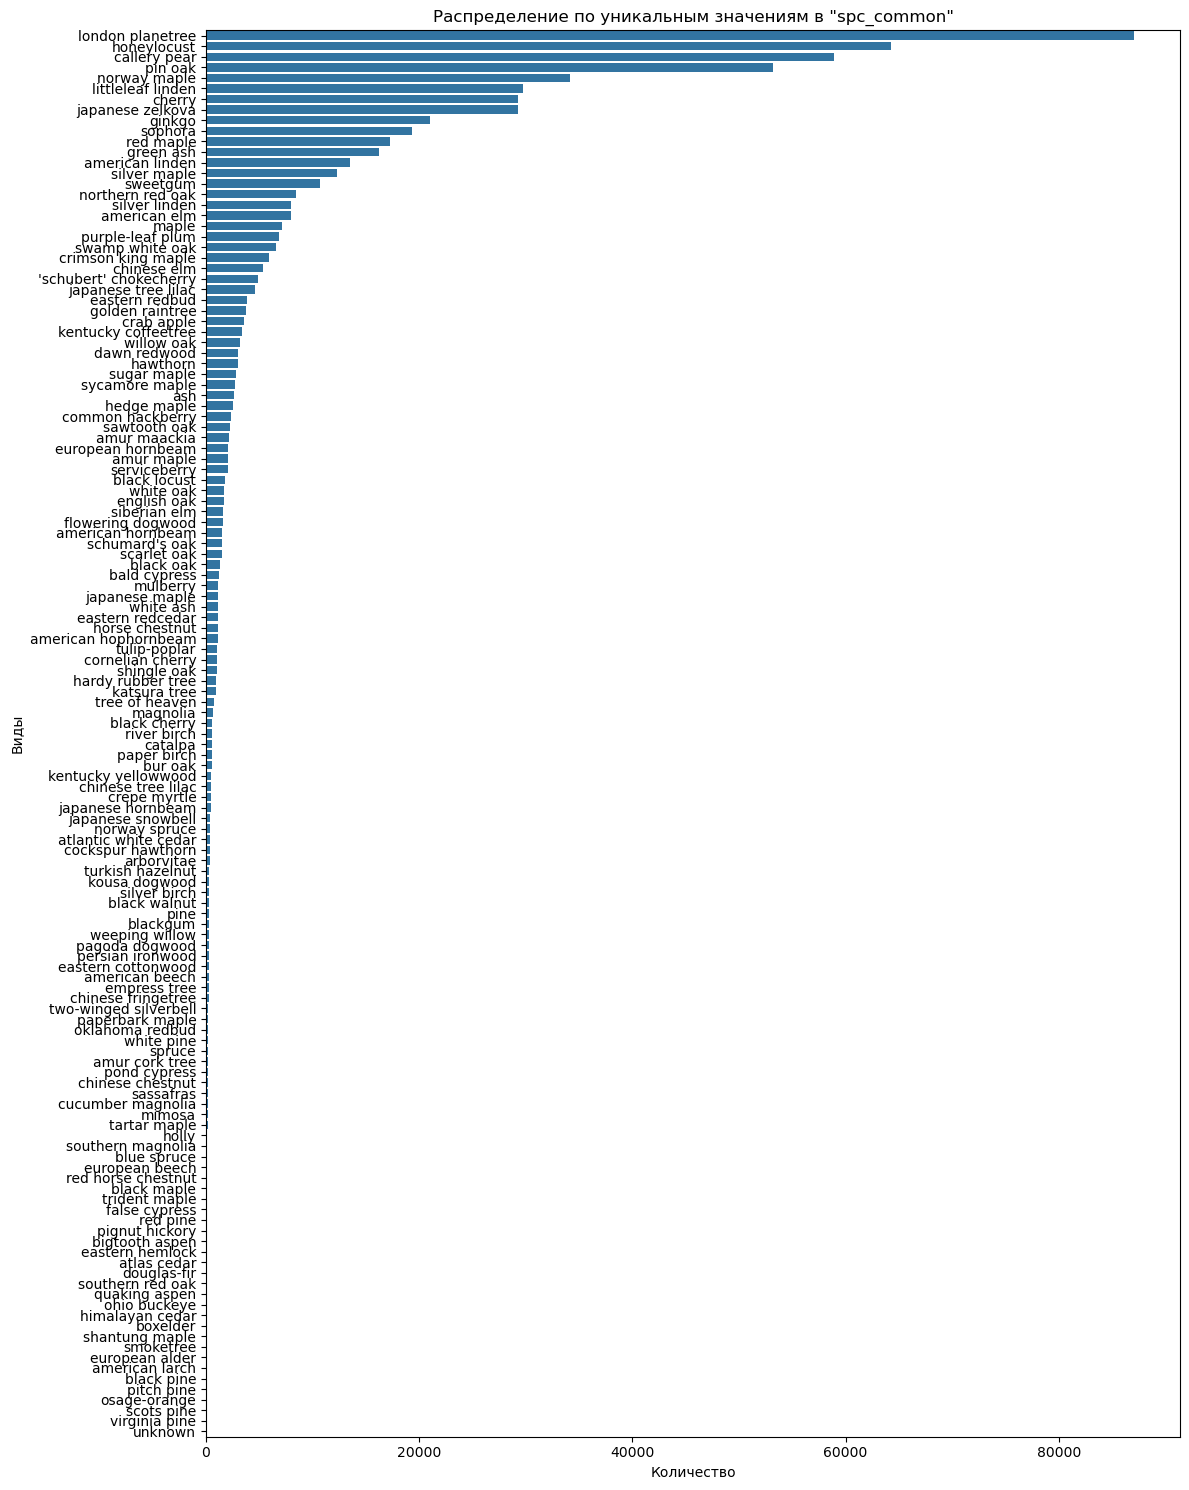

In [47]:
plt.figure(figsize=(12,15))
sns.countplot(y=prepared_data['spc_common'], order=prepared_data['spc_common'].value_counts().index)
plt.title('Распределение по уникальным значениям в "spc_common"')
plt.xlabel('Количество')
plt.ylabel('Виды')

plt.tight_layout()
plt.show()

Как видно, снова Несбалансированный признак

In [49]:
prepared_data.loc[prepared_data['sidewalk'].isna()]

,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,user_type,...,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
346299,7,0,OffsetFromCurb,Alive,Good,honeylocust,unknown,unknown,NaN,TreesCount Staff,...,19,3118800,40.67909,-73.864029,1021964.091,186716.496,37.0,1188.0,3094522.0,3.042060e+09


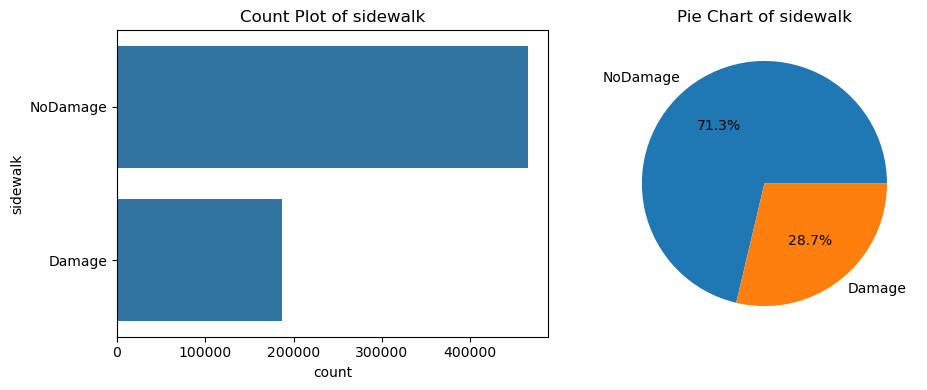

In [50]:
create_stat_plots(prepared_data, 'sidewalk')

Предалагю этот единственный пропуск заменить наиболее встречаещемся значением ().

In [52]:
fill_na_by_frequent(prepared_data, 'sidewalk')

Пропуск заменен на NoDamage


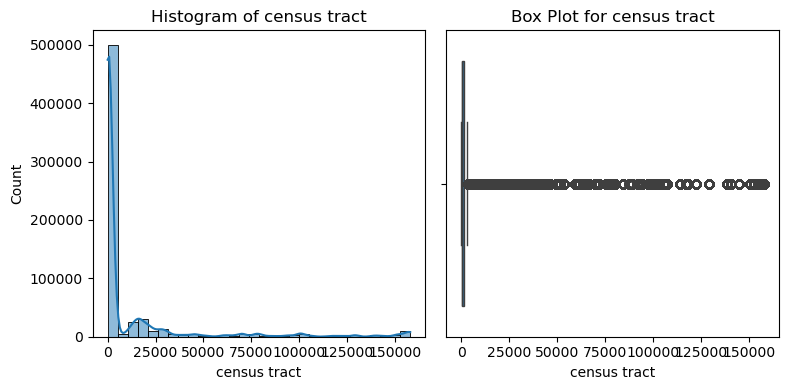

In [53]:
create_stat_plots(prepared_data, 'census tract')

In [54]:
prepared_data.loc[prepared_data['census tract'].isna() & prepared_data['bin'].isna() & prepared_data['bbl'].isna() & prepared_data['council district'].isna()]

,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,user_type,...,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
8,6,0,OnCurb,Alive,Good,honeylocust,unknown,unknown,NoDamage,TreesCount Staff,...,23,5006400,40.596579,-74.076255,9.630732e+05,156635.5542,NaN,NaN,NaN,NaN
68,18,0,OnCurb,Alive,Good,pin oak,unknown,unknown,NoDamage,Volunteer,...,30,1019701,40.802301,-73.962080,9.947484e+05,231579.2036,NaN,NaN,NaN,NaN
213,7,0,OnCurb,Alive,Good,honeylocust,1or2,Helpful,NoDamage,Volunteer,...,28,1008000,40.747801,-73.978580,9.901852e+05,211721.5855,NaN,NaN,NaN,NaN
235,2,0,OffsetFromCurb,Alive,Fair,honeylocust,1or2,unknown,NoDamage,TreesCount Staff,...,15,4093800,40.582117,-73.828646,1.031847e+06,151404.0424,NaN,NaN,NaN,NaN
259,2,0,OffsetFromCurb,Alive,Good,honeylocust,1or2,unknown,NoDamage,TreesCount Staff,...,15,4093800,40.582215,-73.828310,1.031940e+06,151439.7438,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683425,6,0,OffsetFromCurb,Alive,Good,crab apple,unknown,unknown,NoDamage,TreesCount Staff,...,27,1014900,40.771645,-73.982214,9.891763e+05,220408.3624,NaN,NaN,NaN,NaN
683592,7,0,OnCurb,Alive,Good,honeylocust,1or2,Helpful,NoDamage,Volunteer,...,28,1008000,40.747885,-73.978519,9.902019e+05,211752.0867,NaN,NaN,NaN,NaN
683605,2,0,OffsetFromCurb,Alive,Fair,honeylocust,1or2,unknown,NoDamage,TreesCount Staff,...,15,4093800,40.582279,-73.828090,1.032002e+06,151463.2106,NaN,NaN,NaN,NaN
683626,6,0,OnCurb,Alive,Fair,honeylocust,unknown,unknown,NoDamage,Volunteer,...,15,4095400,40.588803,-73.801862,1.039281e+06,153855.5545,NaN,NaN,NaN,NaN


In [55]:
print('Всего пропусков в "census tract, bin, bbl, council district" -', round(prepared_data[['census tract', 'bin', 'bbl', 'council district']].isna().mean().mean() * 100, 2), '%')

Всего пропусков в "census tract, bin, bbl, council district" - 1.17 %


In [56]:
prepared_data = prepared_data.dropna(subset=['census tract', 'bin', 'bbl', 'council district'], how='all')

In [57]:
display_data(prepared_data)

,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,user_type,...,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,3,0,OnCurb,Alive,Fair,red maple,unknown,unknown,NoDamage,TreesCount Staff,...,16,4073900,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,21,0,OnCurb,Alive,Fair,pin oak,unknown,unknown,Damage,TreesCount Staff,...,11,4097300,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,3,0,OnCurb,Alive,Good,honeylocust,1or2,unknown,Damage,Volunteer,...,18,3044900,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,10,0,OnCurb,Alive,Good,honeylocust,unknown,unknown,Damage,Volunteer,...,18,3044900,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,21,0,OnCurb,Alive,Good,american linden,unknown,unknown,Damage,Volunteer,...,21,3016500,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


<class 'pandas.core.frame.DataFrame'>
Index: 646022 entries, 0 to 683787
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_dbh          646022 non-null  int64  
 1   stump_diam        646022 non-null  int64  
 2   curb_loc          646022 non-null  object 
 3   status            646022 non-null  object 
 4   health            646022 non-null  object 
 5   spc_common        646022 non-null  object 
 6   steward           646022 non-null  object 
 7   guards            646022 non-null  object 
 8   sidewalk          646022 non-null  object 
 9   user_type         646022 non-null  object 
 10  root_stone        646022 non-null  object 
 11  root_grate        646022 non-null  object 
 12  root_other        646022 non-null  object 
 13  trunk_wire        646022 non-null  object 
 14  trnk_light        646022 non-null  object 
 15  trnk_other        646022 non-null  object 
 16  brch_light        646022 

None

,tree_dbh,stump_diam,community board,borocode,cncldist,st_assem,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
count,646022.000000,646022.0,646022.000000,646022.000000,646022.000000,646022.000000,646022.000000,6.460220e+05,646022.000000,646022.000000,6.460220e+05,646022.000000,645966.000000,645966.000000,6.430690e+05,6.430690e+05
mean,11.713799,0.0,344.184474,3.365463,30.077748,50.806366,20.610137,3.412190e+06,40.700638,-73.924796,1.005076e+06,194571.163611,30.078239,11973.235805,3.497817e+06,3.415879e+09
std,8.638356,0.0,115.424663,1.163850,14.314110,18.902634,7.366131,1.172076e+06,0.090197,0.123881,3.436758e+04,32860.538408,14.316280,30777.460217,1.193729e+06,1.175564e+09
min,0.000000,0.0,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792200,1.000000,1.000000,1.000000e+06,0.000000e+00
25%,5.000000,0.0,303.000000,3.000000,19.000000,33.000000,14.000000,3.012801e+06,40.631550,-73.981059,9.895036e+05,169378.088425,19.000000,202.000000,3.032695e+06,3.011480e+09
50%,10.000000,0.0,402.000000,4.000000,30.000000,52.000000,21.000000,4.008300e+06,40.699592,-73.913552,1.008206e+06,194191.232900,30.000000,515.000000,4.020342e+06,4.008560e+09
75%,16.000000,0.0,412.000000,4.000000,43.000000,64.000000,25.000000,4.103300e+06,40.761501,-73.835942,1.029703e+06,216758.746750,43.000000,1417.000000,4.264056e+06,4.105810e+09
max,425.000000,0.0,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092100,51.000000,157903.000000,5.515124e+06,5.080500e+09


tree_dbh               0
stump_diam             0
curb_loc               0
status                 0
health                 0
spc_common             0
steward                0
guards                 0
sidewalk               0
user_type              0
root_stone             0
root_grate             0
root_other             0
trunk_wire             0
trnk_light             0
trnk_other             0
brch_light             0
brch_shoe              0
brch_other             0
zip_city               0
community board        0
borocode               0
borough                0
cncldist               0
st_assem               0
st_senate              0
boro_ct                0
latitude               0
longitude              0
x_sp                   0
y_sp                   0
council district      56
census tract          56
bin                 2953
bbl                 2953
dtype: int64

In [58]:
prepared_data.loc[prepared_data['bin'].isna() & prepared_data['bbl'].isna()].shape[0]

2953

Ожидаемо, пропуски в bin и в bll в одних и тех же строках

In [60]:
print('Всего пропусков в "bin, bbl" -', round(prepared_data[['bin', 'bbl']].isna().mean().mean() * 100, 2), '%')

Всего пропусков в "bin, bbl" - 0.46 %


In [61]:
prepared_data = prepared_data.dropna(subset=['bin', 'bbl'], how='all')

In [62]:
prepared_data.loc[prepared_data['census tract'].isna() & prepared_data['council district'].isna()].shape[0]

56

Ожидаемо, пропуски в census tract и в council district в одних и тех же строках

In [64]:
print('Всего пропусков в "census tract, council district" -', round(prepared_data[['census tract', 'council district']].isna().mean().mean() * 100, 2), '%')

Всего пропусков в "census tract, council district" - 0.01 %


In [65]:
prepared_data = prepared_data.dropna(subset=['census tract', 'council district'], how='all')

### 1.2 Обработка аномалий

In [67]:
def delete_outliers(data, target):
    """
    Функция удаления выбросов
    """
    Q1 = data[target].quantile(0.25)
    Q3 = data[target].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data[target] >= lower_bound) & (data[target] <= upper_bound)]
    print('Удаляю выбросы')
    return 

In [68]:
display_data(prepared_data)

,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,user_type,...,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,3,0,OnCurb,Alive,Fair,red maple,unknown,unknown,NoDamage,TreesCount Staff,...,16,4073900,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,21,0,OnCurb,Alive,Fair,pin oak,unknown,unknown,Damage,TreesCount Staff,...,11,4097300,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,3,0,OnCurb,Alive,Good,honeylocust,1or2,unknown,Damage,Volunteer,...,18,3044900,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,10,0,OnCurb,Alive,Good,honeylocust,unknown,unknown,Damage,Volunteer,...,18,3044900,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,21,0,OnCurb,Alive,Good,american linden,unknown,unknown,Damage,Volunteer,...,21,3016500,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


<class 'pandas.core.frame.DataFrame'>
Index: 643013 entries, 0 to 683787
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_dbh          643013 non-null  int64  
 1   stump_diam        643013 non-null  int64  
 2   curb_loc          643013 non-null  object 
 3   status            643013 non-null  object 
 4   health            643013 non-null  object 
 5   spc_common        643013 non-null  object 
 6   steward           643013 non-null  object 
 7   guards            643013 non-null  object 
 8   sidewalk          643013 non-null  object 
 9   user_type         643013 non-null  object 
 10  root_stone        643013 non-null  object 
 11  root_grate        643013 non-null  object 
 12  root_other        643013 non-null  object 
 13  trunk_wire        643013 non-null  object 
 14  trnk_light        643013 non-null  object 
 15  trnk_other        643013 non-null  object 
 16  brch_light        643013 

None

,tree_dbh,stump_diam,community board,borocode,cncldist,st_assem,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
count,643013.000000,643013.0,643013.000000,643013.000000,643013.000000,643013.000000,643013.000000,6.430130e+05,643013.000000,643013.000000,6.430130e+05,643013.000000,643013.000000,643013.000000,6.430130e+05,6.430130e+05
mean,11.721338,0.0,344.186839,3.365437,30.087300,50.804043,20.609320,3.412172e+06,40.700587,-73.924774,1.005082e+06,194552.732093,30.086821,11976.652875,3.497827e+06,3.415891e+09
std,8.641860,0.0,115.396528,1.163572,14.312146,18.899926,7.364556,1.171790e+06,0.090183,0.123870,3.436461e+04,32855.403365,14.314375,30787.518654,1.193715e+06,1.175551e+09
min,0.000000,0.0,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792200,1.000000,1.000000,1.000000e+06,0.000000e+00
25%,5.000000,0.0,303.000000,3.000000,19.000000,33.000000,14.000000,3.012901e+06,40.631510,-73.981039,9.895090e+05,169365.278400,19.000000,202.000000,3.032697e+06,3.011480e+09
50%,10.000000,0.0,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.699462,-73.913531,1.008210e+06,194148.952000,30.000000,515.000000,4.020335e+06,4.008560e+09
75%,16.000000,0.0,412.000000,4.000000,43.000000,64.000000,25.000000,4.103300e+06,40.761420,-73.835912,1.029709e+06,216730.147300,43.000000,1417.000000,4.264049e+06,4.105800e+09
max,425.000000,0.0,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092100,51.000000,157903.000000,5.515124e+06,5.080500e+09


tree_dbh            0
stump_diam          0
curb_loc            0
status              0
health              0
spc_common          0
steward             0
guards              0
sidewalk            0
user_type           0
root_stone          0
root_grate          0
root_other          0
trunk_wire          0
trnk_light          0
trnk_other          0
brch_light          0
brch_shoe           0
brch_other          0
zip_city            0
community board     0
borocode            0
borough             0
cncldist            0
st_assem            0
st_senate           0
boro_ct             0
latitude            0
longitude           0
x_sp                0
y_sp                0
council district    0
census tract        0
bin                 0
bbl                 0
dtype: int64

Проверю остальные признаки на наличие аномалий в данных

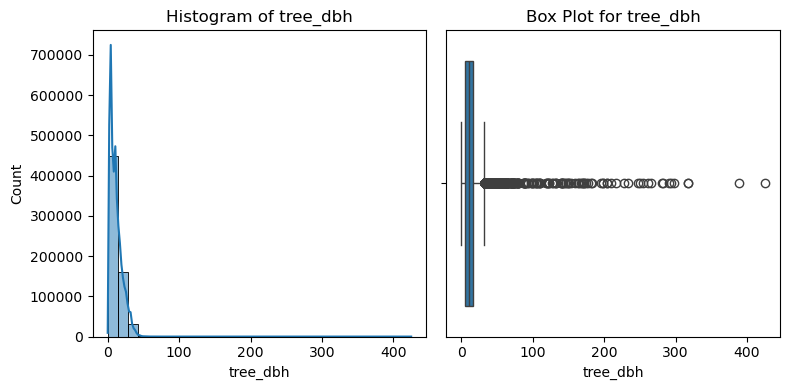

In [70]:
create_stat_plots(prepared_data, 'tree_dbh')

In [71]:
display(prepared_data['tree_dbh'].describe())

count    643013.000000
mean         11.721338
std           8.641860
min           0.000000
25%           5.000000
50%          10.000000
75%          16.000000
max         425.000000
Name: tree_dbh, dtype: float64

Судя по всему, в данных наблюдаются выбросы. Вероято, значения в дюймах и значение 425 дюймов (1079,5 см) явно аномальное.

In [73]:
delete_outliers(prepared_data,'tree_dbh')

Удаляю выбросы


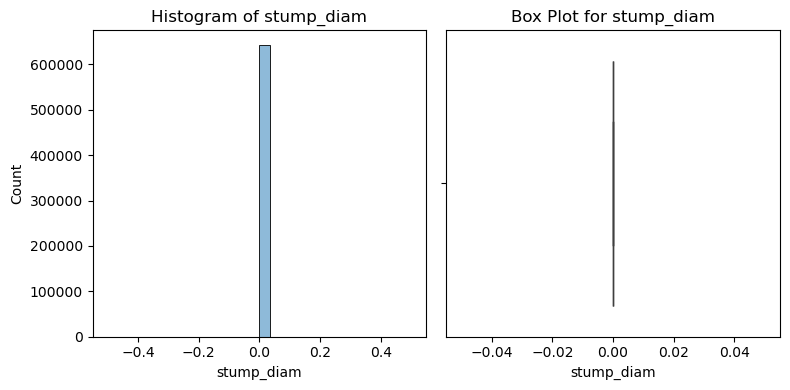

In [74]:
create_stat_plots(prepared_data, 'stump_diam')

In [75]:
display(prepared_data['stump_diam'].describe())

count    643013.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: stump_diam, dtype: float64

Абсолютно неинформативный признак, удалю его

In [77]:
prepared_data = prepared_data.drop('stump_diam', axis=1)

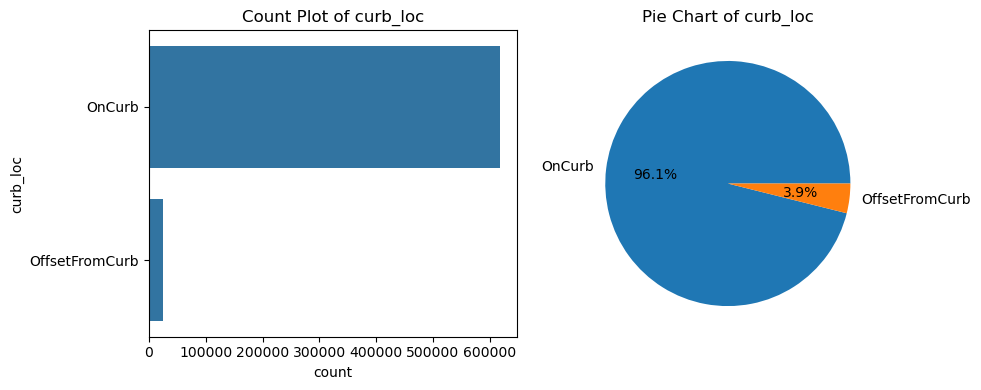

In [78]:
create_stat_plots(prepared_data, 'curb_loc')

Несбалансированный признак

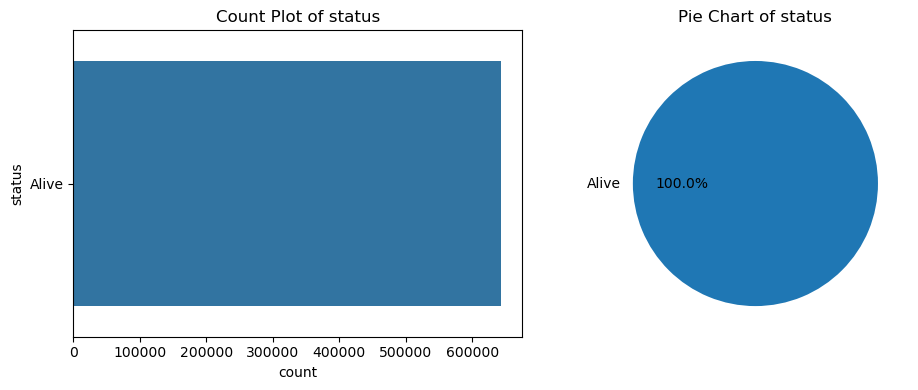

In [80]:
create_stat_plots(prepared_data, 'status')

Абсолютно неинформативный признак, удалю его

In [82]:
prepared_data = prepared_data.drop('status', axis=1)

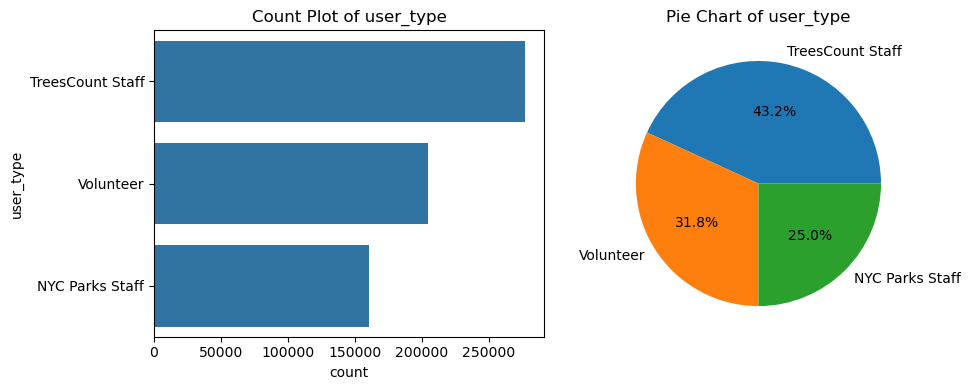

In [83]:
create_stat_plots(prepared_data, 'user_type')

Тут все неплохо

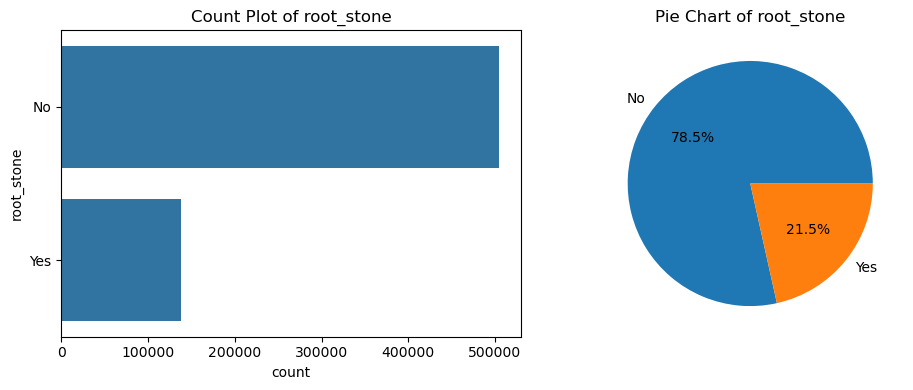

In [85]:
create_stat_plots(prepared_data, 'root_stone')

Несбалансированный признак

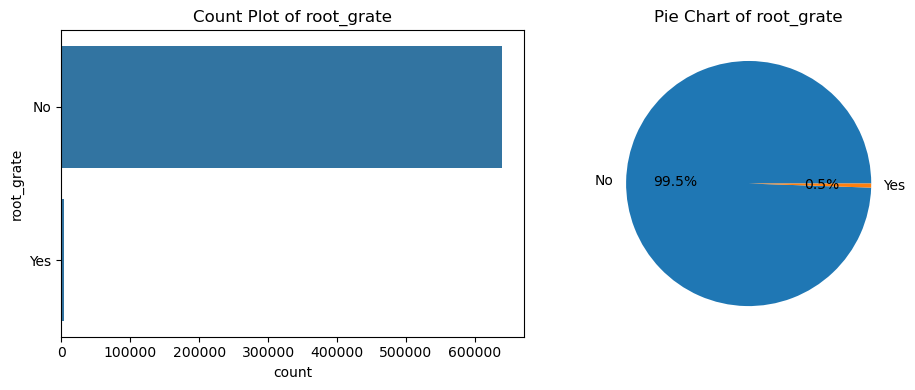

In [87]:
create_stat_plots(prepared_data, 'root_grate')

Несбалансированный признак. Поскольку меток Да меньше процента, от этого признака можно избавиться

In [89]:
prepared_data = prepared_data.drop('root_grate', axis=1)

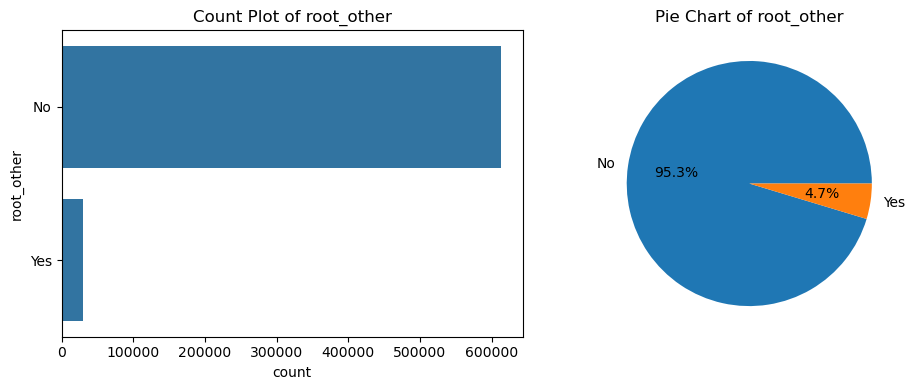

In [90]:
create_stat_plots(prepared_data, 'root_other')

Несбалансированный признак.

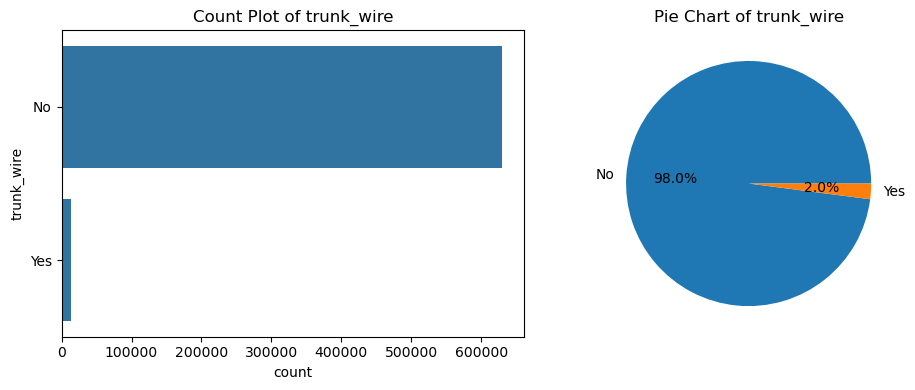

In [92]:
create_stat_plots(prepared_data, 'trunk_wire')

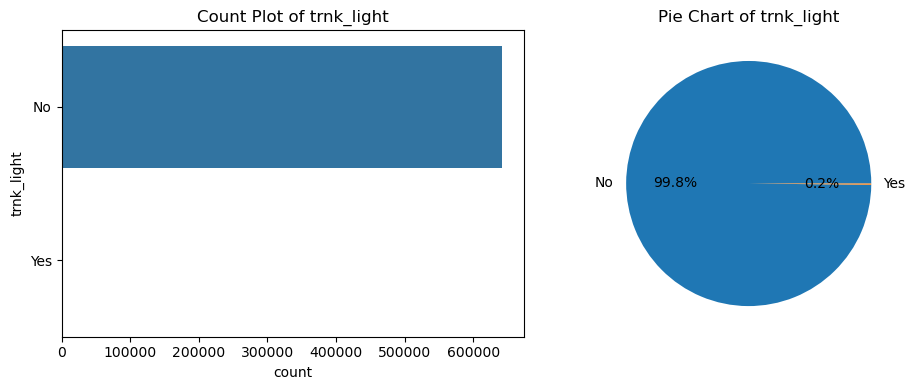

In [93]:
create_stat_plots(prepared_data, 'trnk_light')

Несбалансированный признак. Поскольку меток Да меньше процента, от этого признака можно избавиться

In [95]:
prepared_data = prepared_data.drop('trnk_light', axis=1)

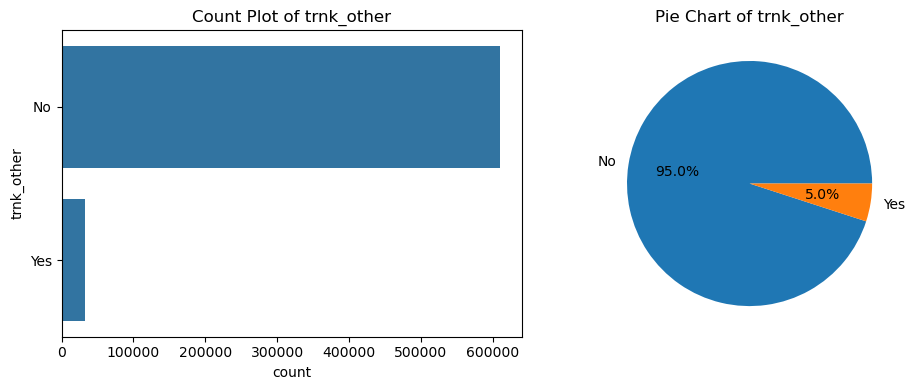

In [96]:
create_stat_plots(prepared_data, 'trnk_other')

Несбалансированный признак.

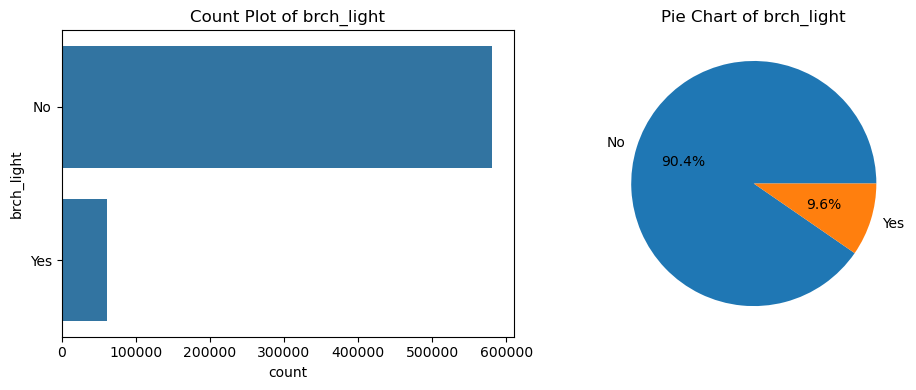

In [98]:
create_stat_plots(prepared_data, 'brch_light')

Несбалансированный признак.

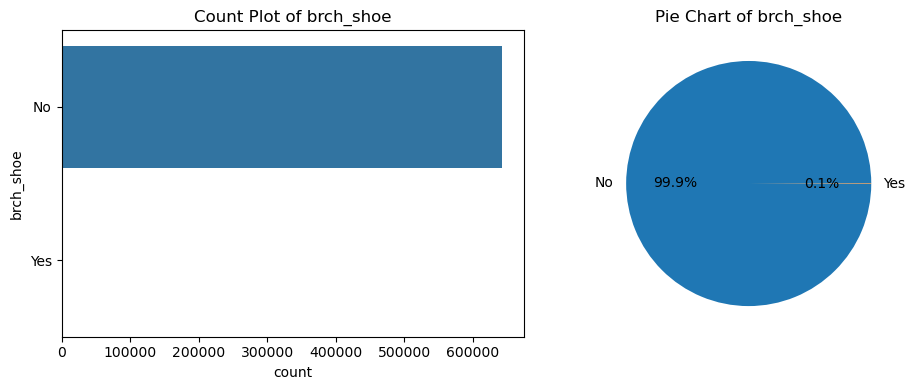

In [100]:
create_stat_plots(prepared_data, 'brch_shoe')

Несбалансированный признак. Поскольку меток Да меньше процента, от этого признака можно избавиться

In [102]:
prepared_data = prepared_data.drop('brch_shoe', axis=1)

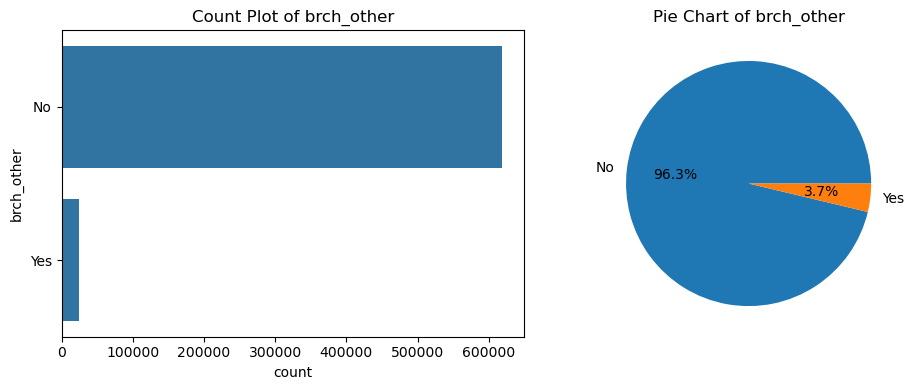

In [103]:
create_stat_plots(prepared_data, 'brch_other')

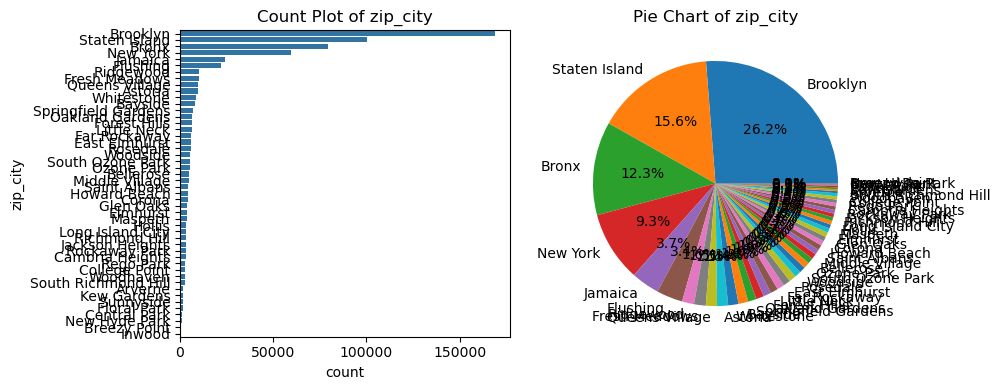

In [104]:
create_stat_plots(prepared_data, 'zip_city')

Объединю признаки с <3% строк в признак Other

In [106]:
threshold = 0.03 * len(prepared_data)
rare_categories = prepared_data['zip_city'].value_counts()[prepared_data['zip_city'].value_counts() < threshold].index

prepared_data['zip_city'] = prepared_data['zip_city'].replace(rare_categories, 'Other')

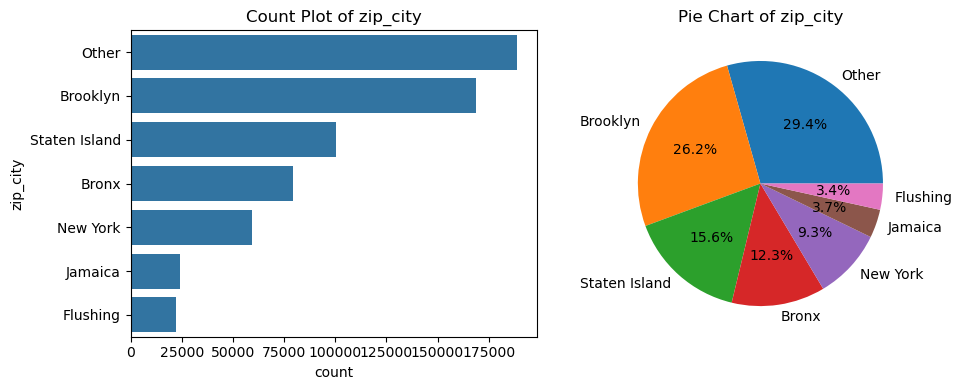

In [107]:
create_stat_plots(prepared_data, 'zip_city')

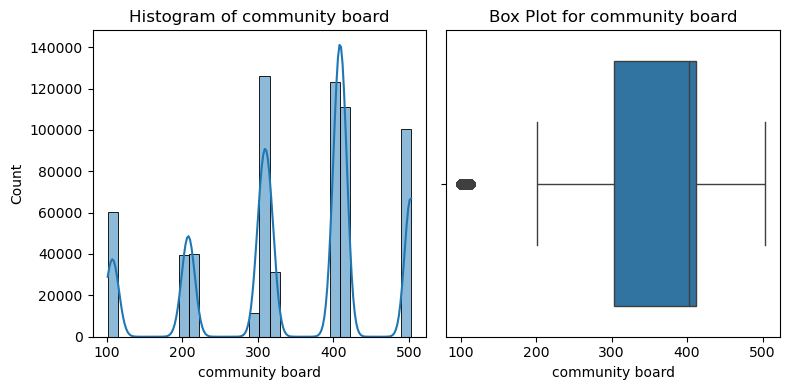

In [108]:
create_stat_plots(prepared_data, 'community board')

In [109]:
prepared_data['community board'].head(10)

0     406
1     407
2     301
3     301
4     306
5     107
6     107
7     104
9     313
10    401
Name: community board, dtype: int64

In [110]:
prepared_data['community board'].unique()

array([406, 407, 301, 306, 107, 104, 313, 401, 503, 302, 316, 311, 314,
       404, 307, 108, 409, 312, 103, 405, 206, 502, 205, 315, 106, 102,
       105, 403, 207, 310, 109, 317, 414, 304, 413, 308, 212, 408, 411,
       318, 208, 101, 110, 402, 412, 204, 211, 410, 305, 203, 303, 209,
       501, 210, 309, 201, 112, 111, 202], dtype=int64)

In [111]:
len(prepared_data['community board'].unique())

59

Судя по описанию в интернете, комюнити боард в Нью-Йорке - административные районы и их 59 штук. Вероятно тут все окей

In [113]:
prepared_data['community board'] = prepared_data['community board'].astype('object')

Меняю тип на Объект

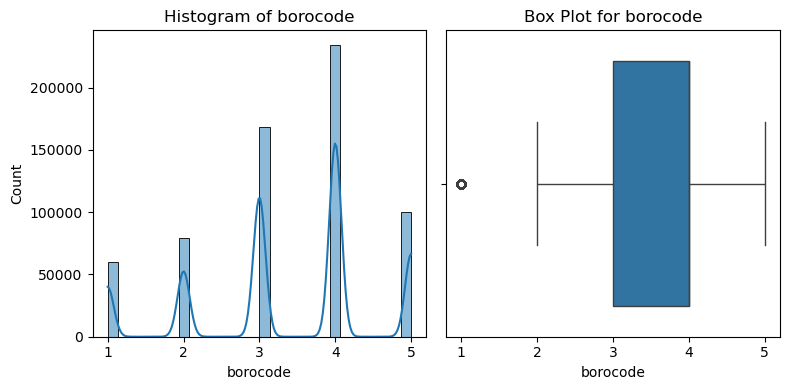

In [115]:
create_stat_plots(prepared_data, 'borocode')

In [116]:
prepared_data['borocode'].unique()

array([4, 3, 1, 5, 2], dtype=int64)

Это также какие-то районы в Нью-Йорке

In [118]:
prepared_data['borocode'] = prepared_data['borocode'].astype('object')

Меняю тип на Объект

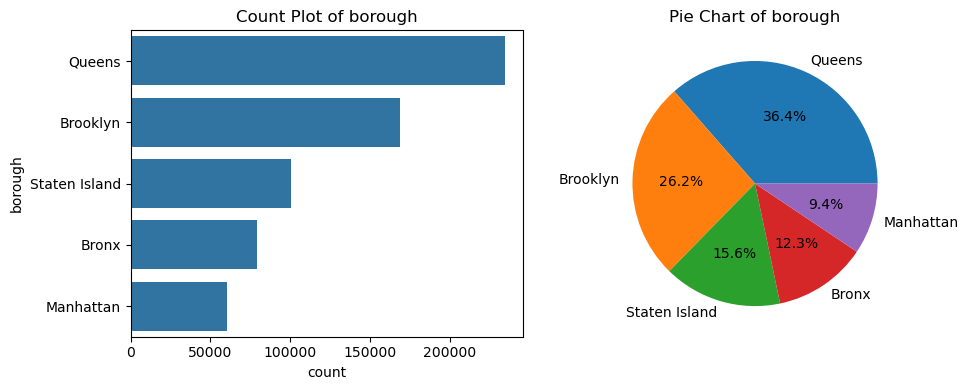

In [120]:
create_stat_plots(prepared_data, 'borough')

Опять районы

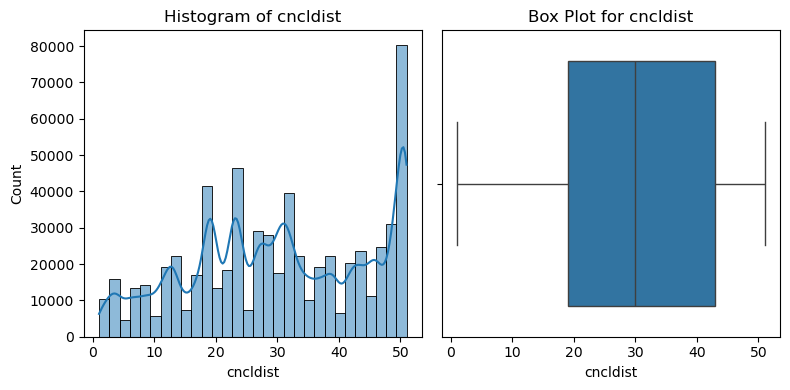

In [122]:
create_stat_plots(prepared_data, 'cncldist')

In [123]:
prepared_data['cncldist'].unique()

array([29, 19, 34, 39,  3, 47, 22, 51, 35, 41, 40, 21, 38,  4,  6, 50, 44,
        1, 17, 15, 48, 20,  2, 25, 11, 14, 43,  7, 45, 31, 37, 27,  5, 30,
       32, 24, 46, 33,  9, 26, 23,  8, 13, 36, 16, 18, 12, 42, 10, 49, 28],
      dtype=int64)

In [124]:
len(prepared_data['cncldist'].unique())

51

Описание из интернета: Город разделён на 51 избирательный округ (Council Districts), и каждый округ выбирает своего представителя в городской совет (City Council).

In [126]:
prepared_data['cncldist'] = prepared_data['cncldist'].astype('object')

Меняю тип на Объект

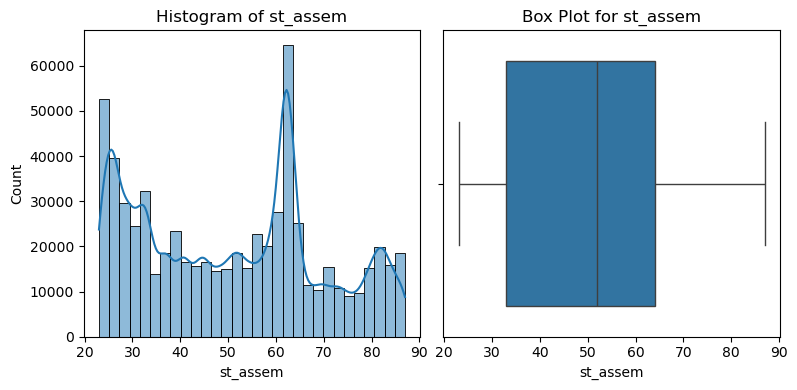

In [128]:
create_stat_plots(prepared_data, 'st_assem')

In [129]:
prepared_data['st_assem'].unique()

array([28, 27, 50, 53, 44, 67, 75, 45, 36, 62, 55, 47, 42, 35, 57, 73, 52,
       48, 65, 37, 86, 64, 74, 66, 63, 41, 25, 78, 39, 80, 77, 46, 26, 69,
       58, 70, 40, 23, 31, 33, 49, 81, 76, 38, 59, 51, 34, 29, 24, 54, 84,
       56, 43, 79, 87, 83, 82, 30, 72, 71, 68, 61, 60, 85, 32],
      dtype=int64)

In [130]:
prepared_data['st_assem'] = prepared_data['st_assem'].astype('object')

Меняю тип на Объект

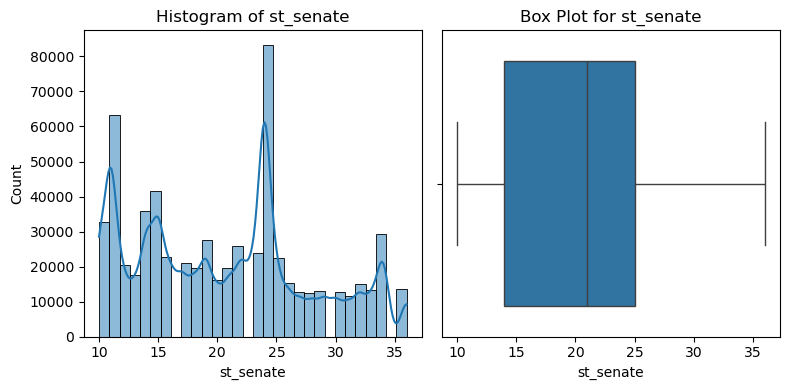

In [132]:
create_stat_plots(prepared_data, 'st_senate')

In [133]:
prepared_data['st_senate'].unique()

array([16, 11, 18, 21, 27, 23, 13, 24, 25, 20, 28, 29, 22, 14, 26, 12, 33,
       17, 31, 36, 15, 30, 10, 34, 32, 19], dtype=int64)

In [134]:
prepared_data['st_senate'] = prepared_data['st_senate'].astype('object')

Меняю тип на Объект

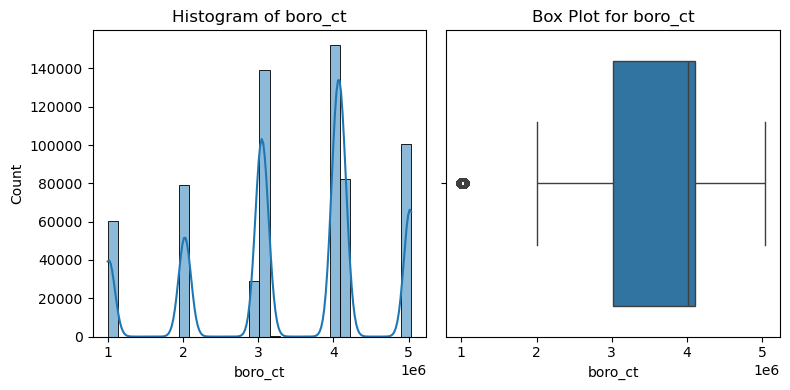

In [136]:
create_stat_plots(prepared_data, 'boro_ct')

In [137]:
prepared_data['boro_ct'].unique()

array([4073900, 4097300, 3044900, ..., 1008400, 3028502, 1031900],
      dtype=int64)

Описание из интернета: Переписной тракт — это небольшая географическая единица, используемая для сбора данных переписи населения.

*Этот признак я не понимю, он мне не интересен. Вот мне он не интересен, за других сказать не могу*

In [139]:
prepared_data = prepared_data.drop('boro_ct', axis=1)

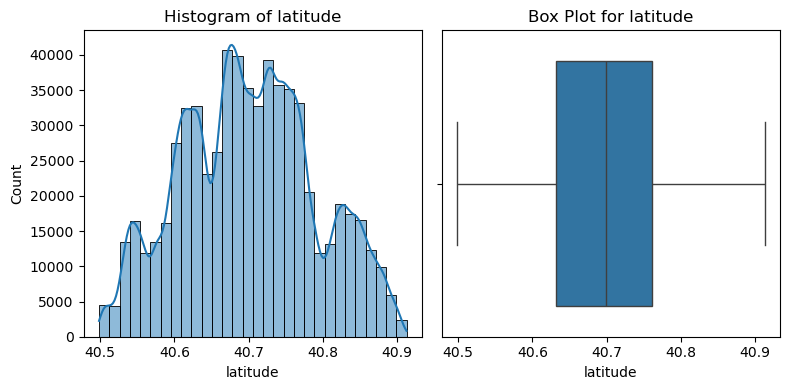

In [140]:
create_stat_plots(prepared_data, 'latitude')

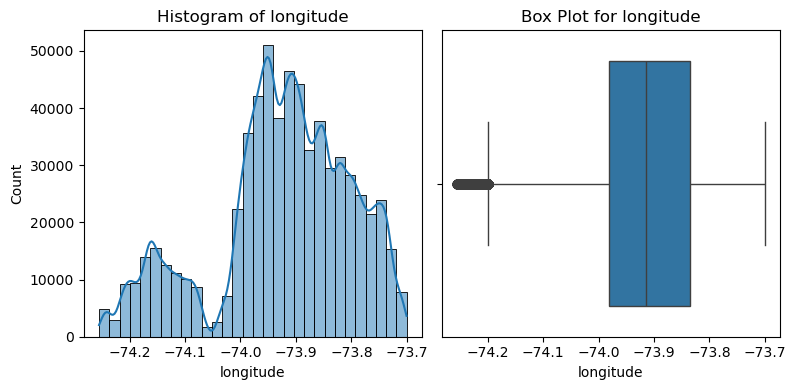

In [141]:
create_stat_plots(prepared_data, 'longitude')

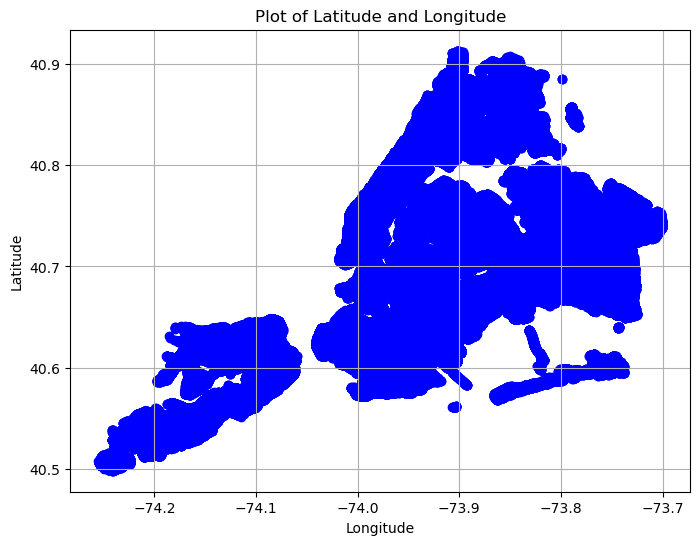

In [142]:
plt.figure(figsize=(8, 6))
plt.scatter(prepared_data['longitude'], prepared_data['latitude'], c='blue', alpha=1)
plt.title('Plot of Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

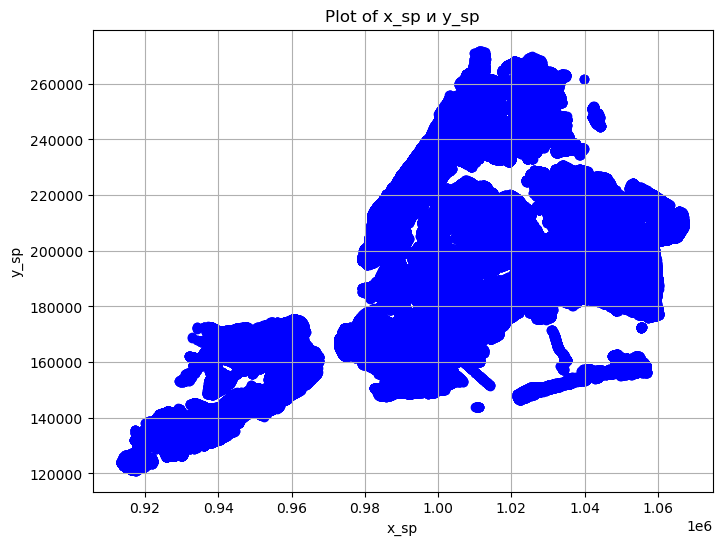

In [143]:
plt.figure(figsize=(8, 6))
plt.scatter(prepared_data['x_sp'], prepared_data['y_sp'], c='blue', alpha=1)
plt.title('Plot of x_sp и y_sp')
plt.xlabel('x_sp')
plt.ylabel('y_sp')
plt.grid(True)
plt.show()

Можно построить графики расположения деревьев в Нью Йорке. В остальном признаки абсолютно неинформативны

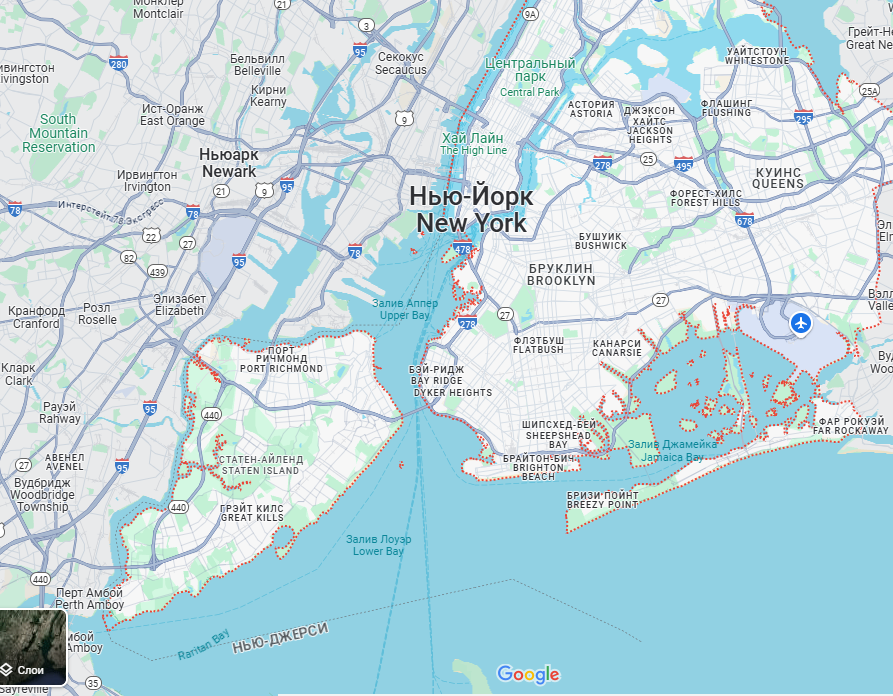

In [146]:
prepared_data = prepared_data.drop(['longitude', 'latitude', 'x_sp', 'y_sp'], axis=1)

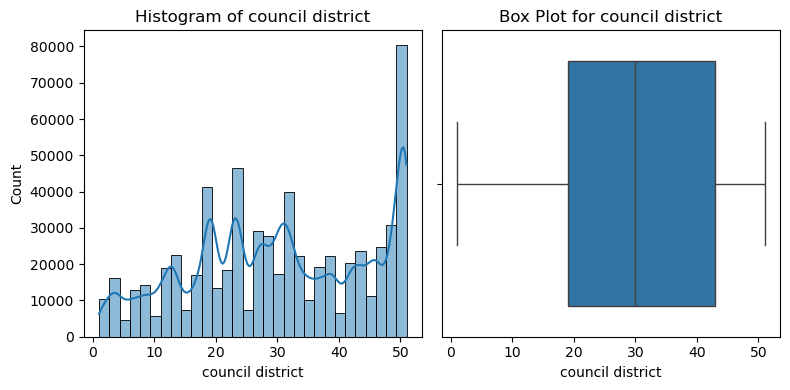

In [147]:
create_stat_plots(prepared_data, 'council district')

In [148]:
prepared_data['council district'].unique()

array([29., 19., 34., 39.,  3., 47., 22., 51., 35., 41., 40., 21.,  4.,
        6., 50., 44.,  1., 17., 15., 48., 20.,  2., 25., 11., 14., 43.,
        7., 45., 31., 37., 27.,  5., 30., 32., 24., 46., 33., 38.,  9.,
       26., 23.,  8., 13., 36., 16., 18., 12., 10., 42., 49., 28.])

In [149]:
len(prepared_data['council district'].unique())

51

In [150]:
prepared_data['council district'] = prepared_data['council district'].astype('object')

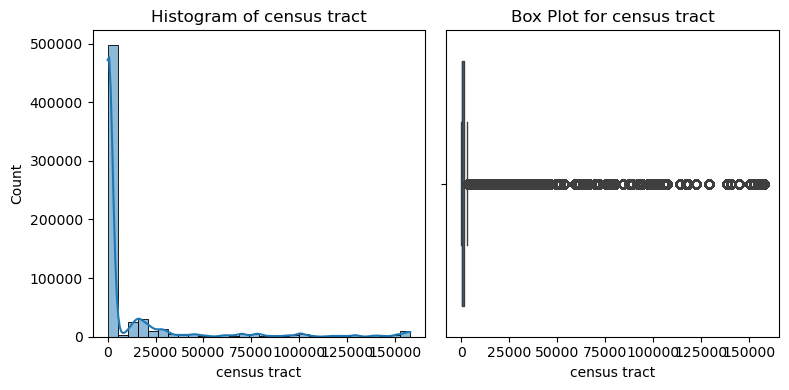

In [151]:
create_stat_plots(prepared_data, 'census tract')

In [152]:
prepared_data['census tract'].unique()

array([  739.,   973.,   449., ...,  1401., 17402., 24302.])

In [153]:
len(prepared_data['census tract'].unique())

1314

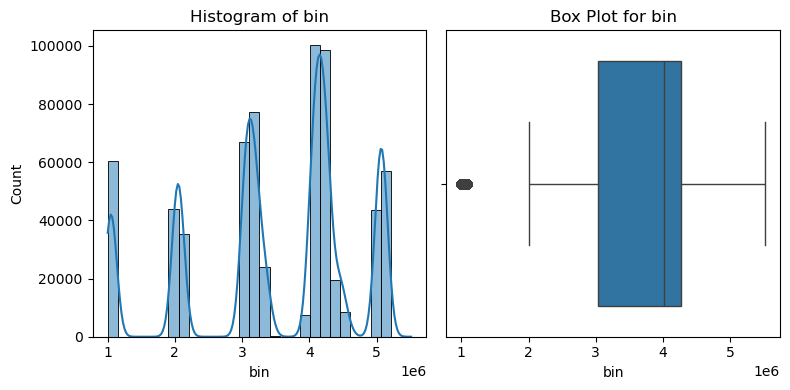

In [154]:
create_stat_plots(prepared_data, 'bin')

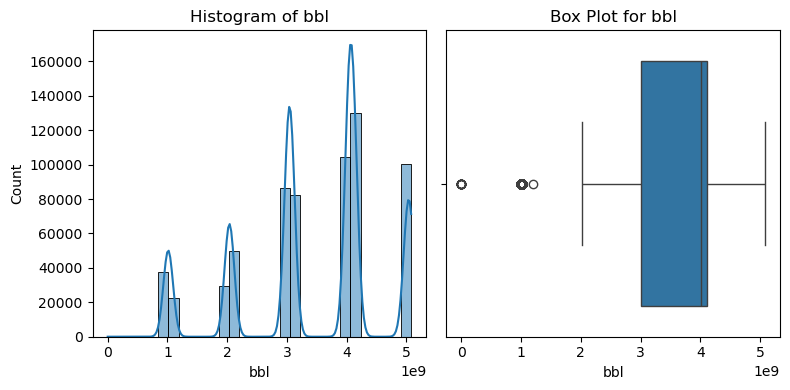

In [155]:
create_stat_plots(prepared_data, 'bbl')

Я не до конца понимаю назначение этих четырех признаков, посмотрю их полезность позже.

## **2. Разделение выборки**

In [158]:
display_data(prepared_data)

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,root_other,...,community board,borocode,borough,cncldist,st_assem,st_senate,council district,census tract,bin,bbl
0,3,OnCurb,Fair,red maple,unknown,unknown,NoDamage,TreesCount Staff,No,No,...,406,4,Queens,29,28,16,29.0,739.0,4052307.0,4.022210e+09
1,21,OnCurb,Fair,pin oak,unknown,unknown,Damage,TreesCount Staff,Yes,No,...,407,4,Queens,19,27,11,19.0,973.0,4101931.0,4.044750e+09
2,3,OnCurb,Good,honeylocust,1or2,unknown,Damage,Volunteer,No,No,...,301,3,Brooklyn,34,50,18,34.0,449.0,3338310.0,3.028870e+09
3,10,OnCurb,Good,honeylocust,unknown,unknown,Damage,Volunteer,Yes,No,...,301,3,Brooklyn,34,53,18,34.0,449.0,3338342.0,3.029250e+09
4,21,OnCurb,Good,american linden,unknown,unknown,Damage,Volunteer,Yes,No,...,306,3,Brooklyn,39,44,21,39.0,165.0,3025654.0,3.010850e+09


<class 'pandas.core.frame.DataFrame'>
Index: 643013 entries, 0 to 683787
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_dbh          643013 non-null  int64  
 1   curb_loc          643013 non-null  object 
 2   health            643013 non-null  object 
 3   spc_common        643013 non-null  object 
 4   steward           643013 non-null  object 
 5   guards            643013 non-null  object 
 6   sidewalk          643013 non-null  object 
 7   user_type         643013 non-null  object 
 8   root_stone        643013 non-null  object 
 9   root_other        643013 non-null  object 
 10  trunk_wire        643013 non-null  object 
 11  trnk_other        643013 non-null  object 
 12  brch_light        643013 non-null  object 
 13  brch_other        643013 non-null  object 
 14  zip_city          643013 non-null  object 
 15  community board   643013 non-null  object 
 16  borocode          643013 

None

,tree_dbh,census tract,bin,bbl
count,643013.000000,643013.000000,6.430130e+05,6.430130e+05
mean,11.721338,11976.652875,3.497827e+06,3.415891e+09
std,8.641860,30787.518654,1.193715e+06,1.175551e+09
min,0.000000,1.000000,1.000000e+06,0.000000e+00
25%,5.000000,202.000000,3.032697e+06,3.011480e+09
50%,10.000000,515.000000,4.020335e+06,4.008560e+09
75%,16.000000,1417.000000,4.264049e+06,4.105800e+09
max,425.000000,157903.000000,5.515124e+06,5.080500e+09


tree_dbh            0
curb_loc            0
health              0
spc_common          0
steward             0
guards              0
sidewalk            0
user_type           0
root_stone          0
root_other          0
trunk_wire          0
trnk_other          0
brch_light          0
brch_other          0
zip_city            0
community board     0
borocode            0
borough             0
cncldist            0
st_assem            0
st_senate           0
council district    0
census tract        0
bin                 0
bbl                 0
dtype: int64

In [159]:
num_features = []
cat_features = []
cat_features_l = []

In [160]:
for col in prepared_data.columns:
    if pd.api.types.is_numeric_dtype(prepared_data[col]):
        num_features.append(col)
    elif pd.api.types.is_object_dtype(prepared_data[col]):
        if prepared_data[col].nunique() > 5:
            cat_features_l.append(col)
        else:
            cat_features.append(col)

cat_features.remove('health')

In [161]:
print("Numerical features:", num_features)
print("Categorical features:", cat_features)
print("Categorical features with more than 5 unique values:", cat_features_l)

Numerical features: ['tree_dbh', 'census tract', 'bin', 'bbl']
Categorical features: ['curb_loc', 'steward', 'guards', 'sidewalk', 'user_type', 'root_stone', 'root_other', 'trunk_wire', 'trnk_other', 'brch_light', 'brch_other', 'borocode', 'borough']
Categorical features with more than 5 unique values: ['spc_common', 'zip_city', 'community board', 'cncldist', 'st_assem', 'st_senate', 'council district']


In [162]:
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')
categorical_large_transformer = BinaryEncoder()

In [163]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features), 
        ('cat', categorical_transformer, cat_features), 
        ('cat_large', categorical_large_transformer, cat_features_l) 
    ]
)

In [164]:
X = prepared_data.drop(columns=['health'])
y = prepared_data['health']

In [165]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

In [166]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(514410, 24)
(64301, 24)
(64302, 24)


## **3. Построение и обучение базовой модели**

В качестве метрик предлагаю рассматривать Accuracy, Precision, Recall, F1-macro и ROC AUC

Accuracy - даст общее представление о предсказаниях модели. Отмечу, что с учетом дисбаланса классов стоит рассматривать эту метрику как относитьельную для оценки моделей между собой
Precision - точность показывает, насколько из всех предсказанных положительных классов модель действительно угадывает правильные
Recall – полнота показывает, какую долю реальных положительных примеров модель смогла найти
F1-macro - гармоническое среднее между precision и recall
ROC AUC - мера качества разделения классов


В качестве основной метрики предлагаю использовать F1-macro, так как она учитывает и точность, и полноту, что особенно важно в условиях дисбаланса классов.

Для оценки модели NN для начала обучу 3 модели из классического МЛ, чтобы было понятно от чего отталкиваться

In [170]:
def train_model(model):
    """
    Функция обучения модели
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    return pipeline

In [171]:
def metrics_report(model):
    """
    Функция вывода метрик
    """

    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro') 
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f'Accuracy: {round(accuracy, 2)}')
    print(f'Precision: {round(precision, 2)}')
    print(f'Recall: {round(recall, 2)}')
    print(f'F1: {round(f1, 2)}')

In [172]:
def roc_auc_plot(model):
    """
    Функция для вывода графика ROC_AUC
    """
    classes = np.unique(y_val)
    y_val_bin = label_binarize(y_val, classes=classes)

    probs = model.predict_proba(X_val)
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(len(classes)): 
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(len(probs[0])):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'r--')
    
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

In [173]:
model = DummyClassifier(strategy='most_frequent')
model.fit(X_train, y_train)

metrics_report(model)

C:\Users\adm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.81
Precision: 0.27
Recall: 0.33
F1: 0.3


Ожидаемо низкие метрики у дамми модели

Accuracy: 0.81
Precision: 0.56
Recall: 0.34
F1: 0.32


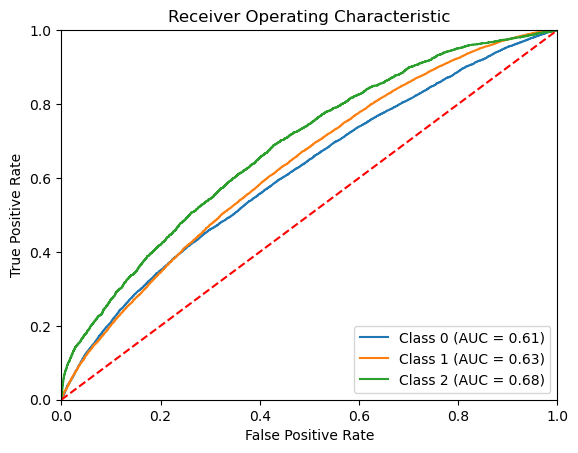

In [175]:
logistic_pipeline = train_model(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))

metrics_report(logistic_pipeline)

roc_auc_plot(logistic_pipeline)

Точность у линейной модели возрасла, однако Ф1 осталась примерно на том же уровне

Значение АUC для всех тех классов немного превышает значение бесполезной модели (AUC которой 0,5)

0:	learn: 0.9971195	total: 178ms	remaining: 2m 57s
200:	learn: 0.5260178	total: 7.71s	remaining: 30.7s
400:	learn: 0.5149789	total: 15.2s	remaining: 22.8s
600:	learn: 0.5082550	total: 22.6s	remaining: 15s
800:	learn: 0.5025912	total: 30.4s	remaining: 7.54s
999:	learn: 0.4981367	total: 37.8s	remaining: 0us
Accuracy: 0.81
Precision: 0.63
Recall: 0.37
F1: 0.37


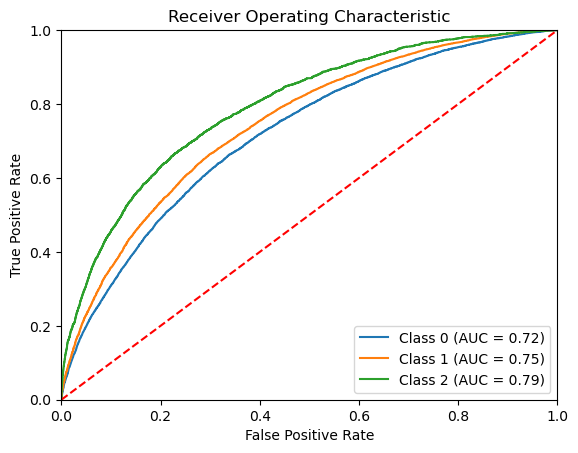

In [177]:
catboost_pipeline = train_model(CatBoostClassifier(
                                                    iterations=1000,
                                                    learning_rate=0.1,
                                                    depth=6,
                                                    verbose=200
                                                ))

metrics_report(catboost_pipeline)

roc_auc_plot(catboost_pipeline)

Бустинг показывает лучшее значение точности, но ф1 метрика все также не высокая. При этом АУК для всех трех классов уже выглядит неплохо, дальшнейшая работа с моделью позволила бы еще улучшить это значение. 

После построения бейслайнов моделей мл есть понимание от чего отталкиваться и будет ли игра стоить свеч

## **4. Построение и обучение нейронной сети**

В качестве модели предлагаю полносвязную нейонную сеть прямого расспространения, как наиболее подходящую архитектуру для обработки табличных значений.

Обучение буду производить на ГПУ

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [183]:
print(torch.__version__) 
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  

2.6.0+cu118
True
NVIDIA GeForce GTX 1650 SUPER


Кодирую данные и перевожу в тензоры

In [185]:
X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)

In [186]:
X_train_tensor = torch.tensor(X_train_encoded, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_encoded, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_encoded, dtype=torch.float32)

In [187]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

In [188]:
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [189]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

Определю 3 класса моделей с одним, двумя и тремя скрытыми слоями

In [191]:
class TreeClassificatorNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TreeClassificatorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        return x

In [192]:
class TreeClassificator2LayersNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(TreeClassificator2LayersNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        
        return x

In [193]:
class TreeClassificator3LayersNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, hidden_size_3, output_size):
        super(TreeClassificator3LayersNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, output_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        
        return x

Функция обучения моделей и подбора лучших гипперпараметров при помощи Оптюны. 

В качестве гипперпараметров выступают:
- тип модели (1, 2, 3 скрытых слоя)
- количество нейронов в скрытых слоях
- - коэффициент обучения (лернинг рейт)
 
Функция потерь - CrossEntropyLoss, оптимизатор - Adam. В качестве метрики используется F1 macro

In [195]:
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['TreeClassificatorNN', 'TreeClassificator2LayersNN', 'TreeClassificator3LayersNN'])
    
    hidden_size = [256, 512, 1024]
    hidden_size_2 = [512, 1024, 2048] 

    hidden_size_1 = trial.suggest_int('hidden_size_1', 256, 1024, step=256)

    if model_type in ['TreeClassificator2LayersNN', 'TreeClassificator3LayersNN']:
        hidden_size_2_value = trial.suggest_int('hidden_size_2', 512, 2048, step=512)
    else:
        hidden_size_2_value = None 

    if model_type == 'TreeClassificator3LayersNN':
        hidden_size_3 = trial.suggest_int('hidden_size_3', 512, 2048, step=512)
        model = TreeClassificator3LayersNN(input_size, hidden_size_1, hidden_size_2_value, hidden_size_3, output_size)
    elif model_type == 'TreeClassificator2LayersNN':
        model = TreeClassificator2LayersNN(input_size, hidden_size_1, hidden_size_2_value, output_size)
    else:
        model = TreeClassificatorNN(input_size, hidden_size_1, output_size)

    model = model.to(device)

    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    val_data = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

    epochs = EPOCHS

    best_f1 = -float('inf')
    best_model = None
    
    model.train()
    for epoch in range(epochs):
        epoch_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_X, batch_y in epoch_progress:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_progress.set_postfix(loss=loss.item())

    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validation", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(batch_y.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='macro') 

    return f1

Обучение модели...

In [214]:
input_size = X_train_tensor.shape[1]
input_size

69

In [224]:
output_size = len(torch.unique(y_train_tensor))
output_size

3

In [226]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

[I 2025-02-06 17:29:29,211] A new study created in memory with name: no-name-6e39f20e-51e5-4ff9-bcca-aabcc8e92ce4
[I 2025-02-06 17:32:44,163] Trial 0 finished with value: 0.08642175839447015 and parameters: {'model_type': 'TreeClassificator2LayersNN', 'hidden_size_1': 768, 'hidden_size_2': 1536, 'lr': 0.045853849167191166}. Best is trial 0 with value: 0.08642175839447015.


После обучения произвожу оценку наилучшей модели

In [245]:
best_trial = study.best_trial
best_trial

FrozenTrial(number=0, state=1, values=[0.08642175839447015], datetime_start=datetime.datetime(2025, 2, 6, 17, 29, 29, 212653), datetime_complete=datetime.datetime(2025, 2, 6, 17, 32, 44, 162652), params={'model_type': 'TreeClassificator2LayersNN', 'hidden_size_1': 768, 'hidden_size_2': 1536, 'lr': 0.045853849167191166}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_type': CategoricalDistribution(choices=('TreeClassificatorNN', 'TreeClassificator2LayersNN', 'TreeClassificator3LayersNN')), 'hidden_size_1': IntDistribution(high=1024, log=False, low=256, step=256), 'hidden_size_2': IntDistribution(high=2048, log=False, low=512, step=512), 'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, trial_id=0, value=None)

In [247]:
best_params = best_trial.params
best_params

{'model_type': 'TreeClassificator2LayersNN',
 'hidden_size_1': 768,
 'hidden_size_2': 1536,
 'lr': 0.045853849167191166}

In [249]:
best_model_type = best_params['model_type']
hidden_size_1 = best_params['hidden_size_1']
hidden_size_2_value = best_params.get('hidden_size_2', None)
hidden_size_3 = best_params.get('hidden_size_3', None)
lr = best_params['lr']

In [251]:
if best_model_type == 'TreeClassificator3LayersNN':
    best_model = TreeClassificator3LayersNN(input_size, hidden_size_1, hidden_size_2_value, hidden_size_3, output_size)
elif best_model_type == 'TreeClassificator2LayersNN':
    best_model = TreeClassificator2LayersNN(input_size, hidden_size_1, hidden_size_2_value, output_size)
else:
    best_model = TreeClassificatorNN(input_size, hidden_size_1, output_size)

best_model = best_model.to(device)

In [253]:
study.set_user_attr('best_model_state_dict', best_model.state_dict())

In [255]:
if 'best_model_state_dict' in best_trial.user_attrs:
    best_model.load_state_dict(best_trial.user_attrs['best_model_state_dict'])
else:
    print("Model state_dict not found in best_trial.user_attrs")

Model state_dict not found in best_trial.user_attrs


Test Accuracy: 81.22%
Precision: 0.27
Recall: 0.33
F1: 0.3
ROC AUC: 0.48


C:\Users\adm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


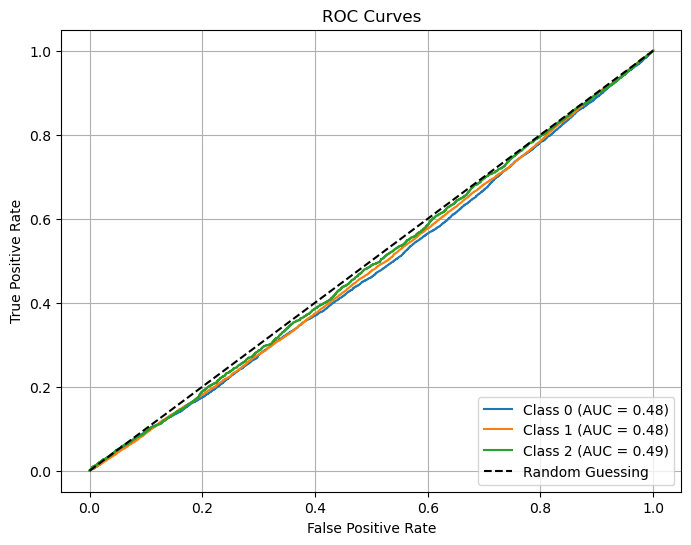

In [257]:
best_model.eval()

with torch.no_grad():
    X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

    outputs = best_model(X_test_tensor)
    probabilities = F.softmax(outputs, dim=1).cpu().numpy()  
    y_true = y_test_tensor.cpu().numpy()

    accuracy = (probabilities.argmax(axis=1) == y_true).sum() / len(y_true)
    precision = precision_score(y_true, probabilities.argmax(axis=1), average='macro') 
    recall = recall_score(y_true, probabilities.argmax(axis=1), average='macro')     
    f1 = f1_score(y_true, probabilities.argmax(axis=1), average='macro') 
    roc_auc = roc_auc_score(y_true, probabilities, multi_class='ovr')

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {round(precision, 2)}")
    print(f"Recall: {round(recall, 2)}")
    print(f"F1: {round(f1, 2)}")
    print(f"ROC AUC: {round(roc_auc, 2)}")


num_classes = probabilities.shape[1]

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true == i, probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

В итоге подбора гипперпараметров и обучения получилась модель со следующими параметрами:

{'model_type': 'TreeClassificator2LayersNN',
 'hidden_size_1': 768,
 'hidden_size_2': 1536,
 'lr': 0.045853849167191166}

 Метрики модели ужасные, не хватило времени для точного подбора гипперпараметров и обучения

Итоговая модель не является идеальной. Метрики достаточно низкие. Для улучшения предсказаний предлагаю следующие варианты:

1) Использовать стандартные модели машинного обучения. Кажется, бустинг моет показать результаты не хуже
2) Пробовать большее количество триалов для оптюны, для выбора лучшего сочетания гипперпараметров
3) Обучать модели на большем количестве эпох
4) Попробовать другие конфигурации для нейронной сети. Изменять количество слоев и количество нейронов в них, а также попробовать другие функции активации
5) Использовать дропаут для уменьшения переобучения
6) Использовать батч нормализацию

Помимо этого помочь с увеличением метрики может более тонкая обработка обучающих данных. Добавление новых признаков, уменьшение дисбаланса, исключение неинформативных метрик - все это может улучшить данные и обучение моделей

Сохраню модель и данные для обращения по АПИ

In [292]:
best_model

TreeClassificator2LayersNN(
  (fc1): Linear(in_features=69, out_features=768, bias=True)
  (fc2): Linear(in_features=768, out_features=1536, bias=True)
  (fc3): Linear(in_features=1536, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [296]:
model_type = best_params['model_type']

if model_type == 'TreeClassificator2LayersNN':
    model_class = TreeClassificator2LayersNN
elif model_type == 'TreeClassificator3LayersNN':
    model_class = TreeClassificator3LayersNN
else:
    model_class = TreeClassificatorNN

model_type

'TreeClassificator2LayersNN'

In [339]:
torch.save({
    'model_class': model_class,  
    'state_dict': best_model.state_dict(),   
}, "best_model.pth")

In [308]:
X_test_np = X_test_tensor.cpu().numpy()
df_X_test = pd.DataFrame(X_test_np)
df_X_test.to_csv("X_test.csv", index=False)